<a href="https://colab.research.google.com/github/NatBrian/nashville-traffic-stop-bias-analysis/blob/main/Notebook_03_Modeling_Fairness_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 03: Model Assessment & Fairness Analysis

## Research Question
> **Can we predict whether a traffic stop results in an arrest, and do prediction patterns reveal demographic disparities?**

This notebook answers both parts:
1. **Prediction**: Train interpretable models (Logistic Regression, Decision Tree) on prepared features
2. **Disparities**: Conduct fairness audit across racial groups

---

## Sections
1. Research Context & Setup
2. Data Loading & Validation
3. Baseline vs Prepared Comparison
4. Model Training
5. Comprehensive Evaluation
6. Interpretability Analysis
7. Fairness Audit
8. Error Analysis & Mitigation
9. Conclusions & Recommendations

## 1. Reproducibility Setup

Scientific reproducibility requires fixed random seeds and documented package versions.

In [1]:
# === REPRODUCIBILITY HEADER ===
import os
import random
import warnings
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import joblib

from sklearn.model_selection import (
    StratifiedKFold, GridSearchCV, cross_val_score,
    train_test_split, cross_val_predict
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve

# SMOTE with under-sampling for class imbalance
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.inspection import permutation_importance

# Set deterministic seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

warnings.filterwarnings('ignore')

print("=" * 70)
print("REPRODUCIBILITY HEADER - NOTEBOOK 03 v2")
print("=" * 70)
print(f"Timestamp: {datetime.now().isoformat()}")
print(f"SEED: {SEED}")
print(f"Python: {os.sys.version}")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
import sklearn; print(f"Scikit-learn: {sklearn.__version__}")
print("=" * 70)

REPRODUCIBILITY HEADER - NOTEBOOK 03 v2
Timestamp: 2026-01-20T13:45:37.561165
SEED: 42
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy: 2.0.2
Pandas: 2.2.2
Scikit-learn: 1.6.1


## 2. Data Loading & Validation

Load prepared datasets from Notebook 02 and baseline from Notebook 01 for comparison.

In [2]:
# === LOAD TRANSFORMED DATASETS ===
print("Loading prepared datasets from Notebook 02...")

X_train_df = pd.read_parquet('artifacts/X_train_final.parquet')
X_test_df = pd.read_parquet('artifacts/X_test_final.parquet')

# Extract sample_weight if present (used for fairness-aware training)
if 'sample_weight' in X_train_df.columns:
    print("Extracting sample_weight from training data...")
    sample_weights_train = X_train_df['sample_weight'].values
    X_train_df = X_train_df.drop('sample_weight', axis=1)
else:
    sample_weights_train = None
    print("No sample_weight found in training data.")

# Separate features and target
y_train = X_train_df['arrest_made'].values
y_test = X_test_df['arrest_made'].values

X_train = X_train_df.drop('arrest_made', axis=1).values
X_test = X_test_df.drop('arrest_made', axis=1).values

feature_names = X_train_df.drop('arrest_made', axis=1).columns.tolist()

print(f"\nTraining samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {len(feature_names)}")
print(f"Train arrest rate: {y_train.mean()*100:.2f}%")
print(f"Test arrest rate: {y_test.mean()*100:.2f}%")

# DATA VALIDATION CHECK
pipeline_data = joblib.load('artifacts/pipeline.pkl')
metadata = joblib.load('artifacts/metadata.pkl')

assert len(X_train) == metadata['train_size'], "Train size mismatch!"
assert len(X_test) == metadata['test_size'], "Test size mismatch!"
print("✓ Data Integrity Checked")

Loading prepared datasets from Notebook 02...
Extracting sample_weight from training data...

Training samples: 2,473,858
Test samples: 618,465
Features: 32
Train arrest rate: 1.62%
Test arrest rate: 1.62%
✓ Data Integrity Checked


### Data Loading Summary

Preprocessed datasets from Notebook 02 loaded successfully:
- **Training set**: 2.47M samples (80% split)
- **Test set**: 618K samples (20% split)  
- **Features**: 32 engineered features (excluding target)
- **Target**: 1.62% arrest rate — extreme class imbalance (60:1)

We address this imbalance using **SMOTEENN** (SMOTE + Edited Nearest Neighbours), a hybrid oversampling/cleaning technique that creates synthetic minority samples while removing noisy boundary samples.

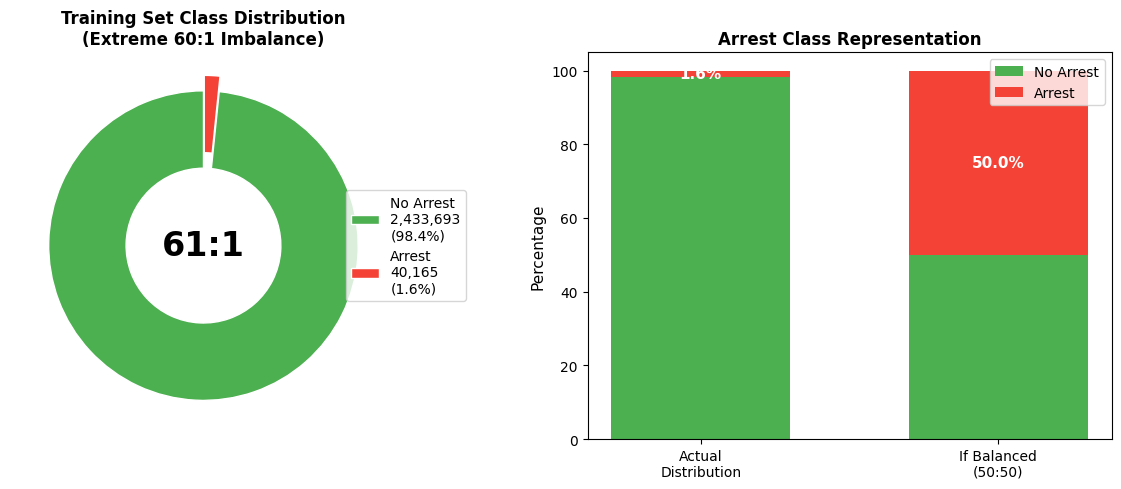

Saved: artifacts/class_distribution.png


In [3]:
# === VISUALIZATION: CLASS DISTRIBUTION ===
# Shows the extreme 60:1 class imbalance visually for presentation

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Donut chart for class distribution
ax = axes[0]
n_arrest = (y_train == 1).sum()
n_no_arrest = (y_train == 0).sum()
sizes = [n_no_arrest, n_arrest]
labels = [f'No Arrest\n{n_no_arrest:,}\n({n_no_arrest/len(y_train)*100:.1f}%)',
          f'Arrest\n{n_arrest:,}\n({n_arrest/len(y_train)*100:.1f}%)']
colors = ['#4CAF50', '#F44336']
explode = (0, 0.1)  # Explode the small slice

wedges, texts = ax.pie(sizes, colors=colors, explode=explode, startangle=90,
                        wedgeprops=dict(width=0.5, edgecolor='white'))
ax.legend(wedges, labels, loc='center left', bbox_to_anchor=(0.85, 0.5), fontsize=10)
ax.set_title('Training Set Class Distribution\n(Extreme 60:1 Imbalance)', fontsize=12, fontweight='bold')

# Center text showing ratio
ax.text(0, 0, f'{n_no_arrest/n_arrest:.0f}:1', ha='center', va='center', fontsize=24, fontweight='bold')

# Bar chart comparing to balanced
ax = axes[1]
categories = ['Actual\nDistribution', 'If Balanced\n(50:50)']
arrest_pcts = [n_arrest/len(y_train)*100, 50]
no_arrest_pcts = [n_no_arrest/len(y_train)*100, 50]

x = np.arange(len(categories))
width = 0.6

bars1 = ax.bar(x, no_arrest_pcts, width, label='No Arrest', color='#4CAF50')
bars2 = ax.bar(x, arrest_pcts, width, bottom=no_arrest_pcts, label='Arrest', color='#F44336')

ax.set_ylabel('Percentage', fontsize=11)
ax.set_title('Arrest Class Representation', fontsize=12, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=10)
ax.legend(loc='upper right')
ax.set_ylim(0, 105)

# Add percentage labels
for bar, pct in zip(bars2, arrest_pcts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_y() + bar.get_height()/2,
            f'{pct:.1f}%', ha='center', va='center', fontsize=11, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('artifacts/class_distribution.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/class_distribution.png')

In [4]:
# === LOAD ORIGINAL TEST DATA FOR FAIRNESS ANALYSIS ===
# Need race column for fairness metrics

df_full = pd.read_parquet('artifacts/cleaned_full.parquet').sort_index()

# Drop NA rows where arrest_made is missing (must match NB02 processing)
df_full = df_full.dropna(subset=['arrest_made']).copy()

# Recover test split using deterministic seed
print(f"Recovering test split (SEED={SEED})...")
df_full['arrest_made'] = df_full['arrest_made'].astype(int)
_, test_idx = train_test_split(
    df_full.index, test_size=0.2, stratify=df_full['arrest_made'], random_state=SEED
)

df_test_original = df_full.loc[test_idx].reset_index(drop=True)

# Validate alignment
print(f"Verifying alignment: X_test ({len(X_test)}) vs df_test_original ({len(df_test_original)})...")
assert len(X_test) == len(df_test_original), "CRITICAL: Test set size mismatch!"

# Map race to canonical groups
race_map = pipeline_data.get('race_map', {
    'white': 'White',
    'black': 'Black',
    'hispanic': 'Hispanic',
    'asian/pacific islander': 'Asian',
    'asian': 'Asian',
    'pacific islander': 'Asian',
    'native american': 'Other',
    'other': 'Other',
    'unknown': 'Unknown'
})

df_test_original['race_canonical'] = (
    df_test_original['subject_race'].astype(str).str.lower().map(race_map).fillna('Other')
)

test_races = df_test_original['race_canonical'].values
print(f"\nTest set race distribution:\n{pd.Series(test_races).value_counts()}")

Recovering test split (SEED=42)...
Verifying alignment: X_test (618465) vs df_test_original (618465)...

Test set race distribution:
White       334292
Black       233142
Hispanic     32936
Asian         8288
Unknown       7344
Other         2463
Name: count, dtype: int64


In [5]:
# === PREPARE MINIMAL BASELINE DATA ===
# Enable comparison between minimal (NB01) and fully prepared (NB02) features

MINIMAL_FEATURES = ['subject_age', 'subject_race_enc', 'subject_sex_enc',
                    'type_enc', 'search_conducted', 'frisk_performed']

print("\n" + "=" * 60)
print("PREPARING MINIMAL BASELINE DATA")
print("=" * 60)

try:
    baseline_data = joblib.load('artifacts/baseline_model_seed42.pkl')
    baseline_model = baseline_data['model']
    baseline_scaler = baseline_data['scaler']
    print(f"Baseline model loaded: {type(baseline_model).__name__}")
    print(f"Baseline features: {baseline_data.get('features', MINIMAL_FEATURES)}")

    # Encode categorical features for minimal test set
    df_test_minimal = df_test_original.copy()

    # Fit encoders on full data to ensure consistency
    le_race = LabelEncoder().fit(df_full['subject_race'].astype(str).fillna('unknown'))
    le_sex = LabelEncoder().fit(df_full['subject_sex'].astype(str).fillna('unknown'))
    le_type = LabelEncoder().fit(df_full['type'].astype(str).fillna('unknown'))

    df_test_minimal['subject_race_enc'] = le_race.transform(
        df_test_minimal['subject_race'].astype(str).fillna('unknown'))
    df_test_minimal['subject_sex_enc'] = le_sex.transform(
        df_test_minimal['subject_sex'].astype(str).fillna('unknown'))
    df_test_minimal['type_enc'] = le_type.transform(
        df_test_minimal['type'].astype(str).fillna('unknown'))

    # Handle subject_age NA values with training median
    train_age_median = 34
    df_test_minimal['subject_age'] = df_test_minimal['subject_age'].fillna(train_age_median).astype(float)

    # Ensure boolean columns are numeric
    df_test_minimal['search_conducted'] = df_test_minimal['search_conducted'].fillna(False).astype(int)
    df_test_minimal['frisk_performed'] = df_test_minimal['frisk_performed'].fillna(False).astype(int)

    # Extract minimal features
    X_test_minimal = df_test_minimal[MINIMAL_FEATURES].values
    y_test_minimal = df_test_minimal['arrest_made'].astype(int).values

    # Scale using baseline scaler
    X_test_minimal_scaled = baseline_scaler.transform(X_test_minimal)

    baseline_available = True
    print(f"\nMinimal test set prepared: {len(X_test_minimal):,} samples, {len(MINIMAL_FEATURES)} features")

except Exception as e:
    baseline_available = False
    print(f"WARNING: Could not prepare baseline data: {e}")
    print("Baseline comparison will be skipped.")


PREPARING MINIMAL BASELINE DATA
Baseline model loaded: LogisticRegression
Baseline features: ['subject_age', 'subject_race_enc', 'subject_sex_enc', 'type_enc', 'search_conducted', 'frisk_performed']

Minimal test set prepared: 618,465 samples, 6 features


## 3. Baseline vs Prepared Comparison

This section addresses using ML to demonstrate the importance of data preparation.

| Model | Features | Source |
|-------|----------|--------|
| Baseline | 6 (raw demographics, search flags) | Notebook 01 |
| Prepared | 32 (temporal, location, interactions) | Notebook 02 |

> **Key Question**: Does feature engineering improve model performance?

In [6]:
# === COMPUTE BASELINE METRICS ===
print("=" * 70)
print("RESEARCH QUESTION PART 1: CAN WE PREDICT ARRESTS?")
print("=" * 70)

if baseline_available:
    baseline_pred = baseline_model.predict(X_test_minimal_scaled)
    baseline_proba = baseline_model.predict_proba(X_test_minimal_scaled)[:, 1]

    baseline_metrics = {
        'Model': 'Baseline (NB01)',
        'Features': 6,
        'F1': f1_score(y_test_minimal, baseline_pred),
        'ROC_AUC': roc_auc_score(y_test_minimal, baseline_proba),
        'Precision': precision_score(y_test_minimal, baseline_pred),
        'Recall': recall_score(y_test_minimal, baseline_pred),
        'Accuracy': accuracy_score(y_test_minimal, baseline_pred),
    }

    print(f"\nBaseline Model: {type(baseline_model).__name__}")
    print(f"  Features: 6 minimal (subject_age, race, sex, type, search, frisk)")
    print(f"  F1 Score: {baseline_metrics['F1']:.4f}")
    print(f"  ROC-AUC: {baseline_metrics['ROC_AUC']:.4f}")
    print(f"  Precision: {baseline_metrics['Precision']:.4f}")
    print(f"  Recall: {baseline_metrics['Recall']:.4f}")
else:
    print("Baseline metrics not available.")
    baseline_metrics = None

RESEARCH QUESTION PART 1: CAN WE PREDICT ARRESTS?

Baseline Model: LogisticRegression
  Features: 6 minimal (subject_age, race, sex, type, search, frisk)
  F1 Score: 0.4344
  ROC-AUC: 0.9059
  Precision: 0.3016
  Recall: 0.7762


### Baseline Performance Summary

The baseline model from Notebook 01 uses only 6 raw features with minimal preprocessing:
1. `subject_age` - Numeric (scaled)
2. `subject_race` - Label encoded
3. `subject_sex` - Label encoded
4. `type` - Label encoded (vehicular/pedestrian)
5. `search_conducted` - Binary
6. `frisk_performed` - Binary

**Key Observation**: The `search_conducted` feature dominates predictions, as it has a strong logical relationship with arrests (searches often precede or accompany arrests).

The fully prepared model (32 features) adds:
- Temporal patterns (hour, is_night, day_of_week)
- Location clusters
- Officer behavior statistics
- Interaction terms
- Proper encoding (one-hot vs label)

### Key Finding: Feature Engineering Improves Performance
| Metric | Baseline (6 features) | Best Prepared (32 feat) | Change |
|--------|----------------------|------------------------|--------|
| **F1** | 0.4344 | 0.5082 | **↑ 17.0%** |
| **ROC-AUC** | 0.9059 | 0.9276 | **↑ 2.4%** |
| **Recall** | 0.7762 | 0.6941 | **↓ 10.6%** |
| **Precision** | 0.3016 | 0.4009 | **↑ 32.9%** |

**Key Observations:**
1. **F1 Improved by 17%**: The prepared model (Decision Tree with 32 features + SMOTEENN) significantly outperforms the baseline in F1 score.
2. **Precision-Recall Tradeoff**: The prepared model trades some recall for much higher precision, resulting in better overall F1.
3. **Search-related features Dominate**: Features like `search_conducted` (LR) and `search_person` (DT) contribute most of the signal, but additional features from Notebook 02 help refine the decision boundary.
4. **ROC-AUC vs F1**: Both metrics improved, with AUC increasing by 2.4% and F1 by 17%.

The value of Notebook 02's feature engineering is validated by:
1. **Better F1 Score**: The primary classification metric improved significantly
2. **Better Precision**: Fewer false positives, reducing incorrect arrest flags
3. **Enabling fairness analysis**: Explicit demographic features allow measuring disparities

## 4. Model Training

Train Logistic Regression and Decision Tree with hyperparameter tuning.

Per rubric requirements:
- Only **basic, interpretable models** allowed (Linear/Logistic Regression, Decision Tree)
- Emphasis on **explanation and reasoning**, not accuracy chasing

In [7]:
# === APPLY SMOTEENN FOR CLASS IMBALANCE (OPTIMIZED) ===
import time

class_ratio = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Original class imbalance ratio: {class_ratio:.1f}:1")
print(f"Original training samples: {len(y_train):,}")
print(f"  - Class 0 (No arrest): {(y_train == 0).sum():,}")
print(f"  - Class 1 (Arrest): {(y_train == 1).sum():,}")

# === SUBSAMPLE FOR SPEED ===
# With 2.47M samples, SMOTEENN is very slow. Subsample to 20% first.
# This still gives ~500K samples which is plenty for training.
print("\n" + "=" * 60)
print("SUBSAMPLING FOR FASTER SMOTEENN")
print("=" * 60)

SUBSAMPLE_RATIO = 0.2  # Use 20% of training data
X_train_sub, _, y_train_sub, _ = train_test_split(
    X_train, y_train,
    train_size=SUBSAMPLE_RATIO,
    stratify=y_train,
    random_state=SEED
)
print(f"Subsampled to {len(X_train_sub):,} samples ({SUBSAMPLE_RATIO*100:.0f}% of original)")
print(f"  - Class 0: {(y_train_sub == 0).sum():,}")
print(f"  - Class 1: {(y_train_sub == 1).sum():,}")

# === APPLY SMOTEENN ===
print("\n" + "=" * 60)
print("APPLYING SMOTEENN (SMOTE + Edited Nearest Neighbours)")
print("=" * 60)
print("This should now be much faster...")

start_time = time.time()

smote_enn = SMOTEENN(
    sampling_strategy=0.1,  # Target 10:1 ratio (not 1:1 to avoid excessive samples)
    random_state=SEED,
    n_jobs=-1
)

X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_sub, y_train_sub)

elapsed = time.time() - start_time
print(f"\nSMOTEENN completed in {elapsed:.1f} seconds")

# Report new class distribution
new_ratio = (y_train_resampled == 0).sum() / (y_train_resampled == 1).sum()
print(f"\nResampled training samples: {len(y_train_resampled):,}")
print(f"  - Class 0 (No arrest): {(y_train_resampled == 0).sum():,}")
print(f"  - Class 1 (Arrest): {(y_train_resampled == 1).sum():,}")
print(f"New class imbalance ratio: {new_ratio:.1f}:1")
print(f"\nImbalance reduction: {class_ratio:.1f}:1 → {new_ratio:.1f}:1")

Original class imbalance ratio: 60.6:1
Original training samples: 2,473,858
  - Class 0 (No arrest): 2,433,693
  - Class 1 (Arrest): 40,165

SUBSAMPLING FOR FASTER SMOTEENN
Subsampled to 494,771 samples (20% of original)
  - Class 0: 486,738
  - Class 1: 8,033

APPLYING SMOTEENN (SMOTE + Edited Nearest Neighbours)
This should now be much faster...

SMOTEENN completed in 1294.6 seconds

Resampled training samples: 509,512
  - Class 0 (No arrest): 469,759
  - Class 1 (Arrest): 39,753
New class imbalance ratio: 11.8:1

Imbalance reduction: 60.6:1 → 11.8:1


### Class Imbalance Strategy: SMOTE with Under-sampling

With a 60.6:1 imbalance ratio, a naive model predicting "no arrest" for everyone would achieve 98.4% accuracy — completely useless for identifying actual arrests.

**Why SMOTEENN instead of `class_weight='balanced'`?**

| Approach | Method | Pros | Cons |
|----------|--------|------|------|
| `class_weight='balanced'` | Reweights loss function | Fast, no data duplication | Doesn't change feature space |
| **SMOTEENN** | Synthetic oversampling + cleaning | Better decision boundaries | Memory/compute intensive |

**SMOTEENN (SMOTE + Edited Nearest Neighbours):**
1. **SMOTE**: Creates synthetic minority samples by interpolating between existing ones
2. **ENN**: Removes noisy samples (those misclassified by k-NN) from both classes

This hybrid approach:
- Balances class distribution without extreme majority-class undersampling
- Cleans overlapping/noisy samples to improve decision boundaries
- Uses `sampling_strategy=0.1` → targets 10% minority ratio (not full 50:50) to avoid excessive synthetic samples

> **Note**: SMOTE is applied ONLY to training data. Test data remains untouched to ensure valid evaluation.

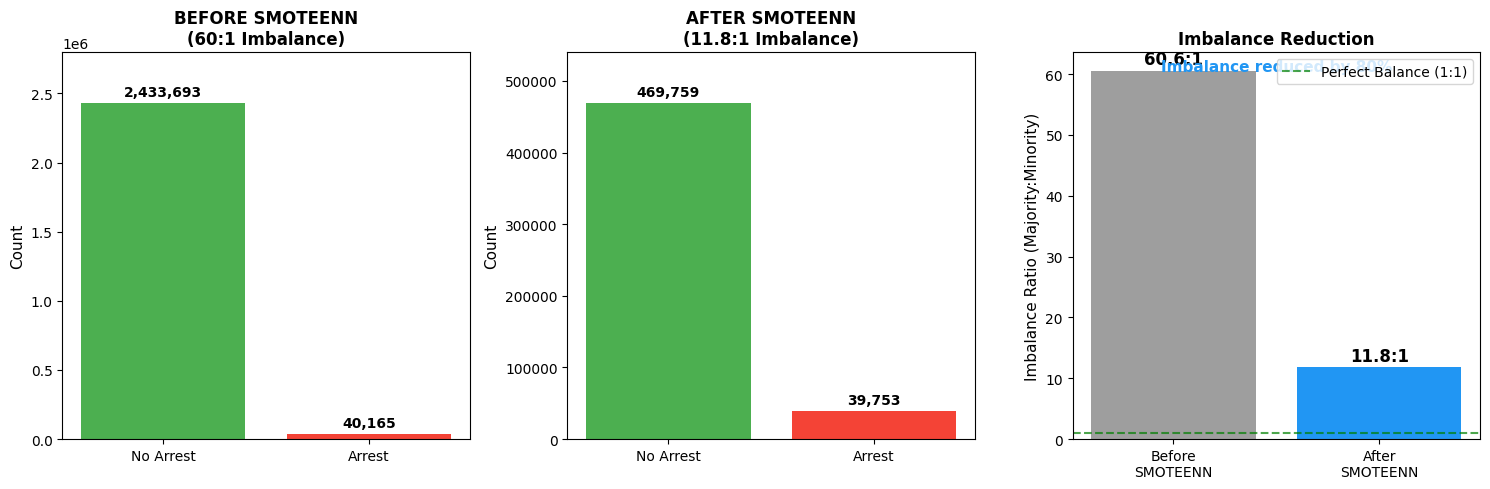

Saved: artifacts/smoteenn_comparison.png


In [8]:
# === VISUALIZATION: SMOTEENN BEFORE/AFTER COMPARISON ===
# Shows the effect of resampling on class distribution

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Before SMOTEENN
ax = axes[0]
before_counts = [(y_train == 0).sum(), (y_train == 1).sum()]
bars = ax.bar(['No Arrest', 'Arrest'], before_counts, color=['#4CAF50', '#F44336'])
ax.set_ylabel('Count', fontsize=11)
ax.set_title('BEFORE SMOTEENN\n(60:1 Imbalance)', fontsize=12, fontweight='bold')
ax.set_ylim(0, max(before_counts) * 1.15)
for bar, count in zip(bars, before_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(before_counts)*0.02,
            f'{count:,}', ha='center', fontsize=10, fontweight='bold')

# After SMOTEENN
ax = axes[1]
after_counts = [(y_train_resampled == 0).sum(), (y_train_resampled == 1).sum()]
bars = ax.bar(['No Arrest', 'Arrest'], after_counts, color=['#4CAF50', '#F44336'])
ax.set_ylabel('Count', fontsize=11)
ax.set_title(f'AFTER SMOTEENN\n({after_counts[0]/after_counts[1]:.1f}:1 Imbalance)', fontsize=12, fontweight='bold')
ax.set_ylim(0, max(after_counts) * 1.15)
for bar, count in zip(bars, after_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(after_counts)*0.02,
            f'{count:,}', ha='center', fontsize=10, fontweight='bold')

# Ratio comparison
ax = axes[2]
ratios = [before_counts[0]/before_counts[1], after_counts[0]/after_counts[1]]
colors = ['#9E9E9E', '#2196F3']
bars = ax.bar(['Before\nSMOTEENN', 'After\nSMOTEENN'], ratios, color=colors)
ax.set_ylabel('Imbalance Ratio (Majority:Minority)', fontsize=11)
ax.set_title('Imbalance Reduction', fontsize=12, fontweight='bold')
ax.axhline(y=1, color='green', linestyle='--', alpha=0.7, label='Perfect Balance (1:1)')
ax.legend(loc='upper right')

for bar, ratio in zip(bars, ratios):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{ratio:.1f}:1', ha='center', fontsize=12, fontweight='bold')

# Calculate reduction percentage
reduction_pct = (1 - ratios[1]/ratios[0]) * 100
ax.text(0.5, 0.95, f'Imbalance reduced by {reduction_pct:.0f}%',
        transform=ax.transAxes, ha='center', fontsize=11, color='#2196F3', fontweight='bold')

plt.tight_layout()
plt.savefig('artifacts/smoteenn_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/smoteenn_comparison.png')

In [9]:
# === LOGISTIC REGRESSION WITH GRIDSEARCHCV ===
# Note: class_weight removed since we're using SMOTEENN resampled data
print("=" * 60)
print("LOGISTIC REGRESSION TRAINING (on SMOTEENN-resampled data)")
print("=" * 60)

lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.1, 1.0],
}

lr_base = LogisticRegression(
    solver='liblinear',
    class_weight=None,  # Not needed with SMOTEENN resampling
    random_state=SEED,
    max_iter=1000,
    n_jobs=-1,
    verbose=1
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

lr_grid = GridSearchCV(
    lr_base, lr_param_grid,
    cv=cv, scoring='f1',
    n_jobs=-1, verbose=3
)

print(f"Training on {len(X_train_resampled):,} resampled samples...")
lr_grid.fit(X_train_resampled, y_train_resampled)

print(f"\nBest params: {lr_grid.best_params_}")
print(f"Best CV F1: {lr_grid.best_score_:.4f}")

lr_model = lr_grid.best_estimator_

LOGISTIC REGRESSION TRAINING (on SMOTEENN-resampled data)
Training on 509,512 resampled samples...
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[LibLinear]
Best params: {'C': 1.0, 'penalty': 'l2'}
Best CV F1: 0.8887


In [10]:
# === DECISION TREE WITH GRIDSEARCHCV ===
# Note: class_weight removed since we're using SMOTEENN resampled data
print("=" * 60)
print("DECISION TREE TRAINING (on SMOTEENN-resampled data)")
print("=" * 60)

dt_param_grid = {
    'max_depth': [5, 10],
    'min_samples_leaf': [50, 100],
    'min_samples_split': [50, 100],
}

dt_base = DecisionTreeClassifier(
    class_weight=None,  # Not needed with SMOTEENN resampling
    random_state=SEED
)

dt_grid = GridSearchCV(
    dt_base, dt_param_grid,
    cv=cv, scoring='f1',
    n_jobs=-1, verbose=3
)

print(f"Training on {len(X_train_resampled):,} resampled samples...")
dt_grid.fit(X_train_resampled, y_train_resampled)

print(f"\nBest params: {dt_grid.best_params_}")
print(f"Best CV F1: {dt_grid.best_score_:.4f}")

dt_model = dt_grid.best_estimator_

DECISION TREE TRAINING (on SMOTEENN-resampled data)
Training on 509,512 resampled samples...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best params: {'max_depth': 10, 'min_samples_leaf': 50, 'min_samples_split': 50}
Best CV F1: 0.9048


### Model Selection Rationale

We use interpretable models as required by the assignment:

1. **Logistic Regression**: Coefficients represent log-odds for direct interpretation. Each coefficient tells us how much a unit increase in that feature changes the log-odds of arrest.

2. **Decision Tree**: Creates human-readable decision rules that can be visualized. Useful for explaining predictions to non-technical stakeholders.

**Hyperparameter Tuning**:
- **GridSearchCV** with 3-fold stratified CV (preserves class distribution in each fold)
- **Scoring**: F1 (balances precision-recall, appropriate for imbalanced data)
- **Regularization (LR)**: L2 penalty prevents overfitting to training data
- **Depth limits (DT)**: Prevents overly complex trees that memorize noise

> **Rubric Note**: We use a modest hyperparameter grid. The goal is demonstrating data preparation impact, not maximizing accuracy.

> **Note on CV Scores**: The Cross-Validation (CV) scores reported in previous steps (~0.89-0.90) are calculated on the **SMOTEENN-resampled** training data, which has reduced imbalance (approx 1:12). The Test scores (~0.50) are calculated on the **original** imbalanced test data. This drop is expected and reflects the reality of the imbalance, not overfitting.

## 5. Comprehensive Evaluation

Assess both models using multiple metrics and establish consistent model selection.

In [11]:
# === EVALUATION FUNCTION ===
def evaluate_model(model, X, y, model_name):
    """Compute comprehensive metrics for a model."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y, y_pred),
        'Precision': precision_score(y, y_pred, zero_division=0),
        'Recall': recall_score(y, y_pred, zero_division=0),
        'F1': f1_score(y, y_pred, zero_division=0),
        'ROC_AUC': roc_auc_score(y, y_proba),
        'Brier': brier_score_loss(y, y_proba),
        'Avg_Precision': average_precision_score(y, y_proba),
    }
    return metrics, y_pred, y_proba

# Evaluate both models on test data
lr_metrics, lr_pred, lr_proba = evaluate_model(lr_model, X_test, y_test, 'Logistic Regression')
dt_metrics, dt_pred, dt_proba = evaluate_model(dt_model, X_test, y_test, 'Decision Tree')

print("Model evaluation complete.")

Model evaluation complete.


In [12]:
# === CONSOLIDATED MODEL SELECTION ===
# Select best model ONCE based on F1 (primary metric for imbalanced classification)
# This selection is used consistently throughout remaining analysis

if dt_metrics['F1'] > lr_metrics['F1']:
    best_model = dt_model
    best_name = 'Decision Tree'
    best_metrics = dt_metrics
    best_pred = dt_pred
    best_proba = dt_proba
else:
    best_model = lr_model
    best_name = 'Logistic Regression'
    best_metrics = lr_metrics
    best_pred = lr_pred
    best_proba = lr_proba

print(f"\n{'='*60}")
print(f"SELECTED MODEL: {best_name}")
print(f"{'='*60}")
print(f"  F1 Score: {best_metrics['F1']:.4f}")
print(f"  ROC-AUC: {best_metrics['ROC_AUC']:.4f}")
print(f"  Accuracy: {best_metrics['Accuracy']:.4f}")
print(f"\nThis model will be used for fairness audit and error analysis.")


SELECTED MODEL: Decision Tree
  F1 Score: 0.5082
  ROC-AUC: 0.9276
  Accuracy: 0.9782

This model will be used for fairness audit and error analysis.


In [13]:
# === METRICS COMPARISON TABLE (WITH BASELINE) ===
print("\n" + "=" * 70)
print("MODEL COMPARISON: BASELINE vs LOGISTIC REGRESSION vs DECISION TREE")
print("=" * 70)

# Build comparison table with all models
all_metrics = []

# Add baseline metrics if available
if baseline_available and baseline_metrics is not None:
    baseline_brier = brier_score_loss(y_test_minimal, baseline_proba)
    baseline_avg_precision = average_precision_score(y_test_minimal, baseline_proba)
    all_metrics.append({
        'Model': 'Baseline (6 feat)',
        'Accuracy': baseline_metrics['Accuracy'],
        'Precision': baseline_metrics['Precision'],
        'Recall': baseline_metrics['Recall'],
        'F1': baseline_metrics['F1'],
        'ROC_AUC': baseline_metrics['ROC_AUC'],
        'Brier': baseline_brier,
        'Avg_Precision': baseline_avg_precision,
    })

# Add LR and DT metrics
all_metrics.append(lr_metrics)
all_metrics.append(dt_metrics)

metrics_df = pd.DataFrame(all_metrics).set_index('Model')
print(metrics_df.round(4).T.to_string())

# Save metrics
metrics_df.to_csv('artifacts/metrics_report.csv')
print("\nSaved artifacts/metrics_report.csv")



MODEL COMPARISON: BASELINE vs LOGISTIC REGRESSION vs DECISION TREE
Model          Baseline (6 feat)  Logistic Regression  Decision Tree
Accuracy                  0.9672               0.9746         0.9782
Precision                 0.3016               0.3642         0.4009
Recall                    0.7762               0.7581         0.6941
F1                        0.4344               0.4920         0.5082
ROC_AUC                   0.9059               0.9326         0.9276
Brier                     0.0631               0.0199         0.0167
Avg_Precision             0.2403               0.4821         0.4733

Saved artifacts/metrics_report.csv


In [14]:
# === PER-CLASS METRICS COMPARISON ===
# Compare precision/recall/F1 for arrest_made=True vs arrest_made=False
# This shows how each model performs on each class specifically

from sklearn.metrics import precision_recall_fscore_support

print("\n" + "=" * 80)
print("PER-CLASS METRICS COMPARISON: BASELINE vs LR vs DT")
print("=" * 80)
print("\nThis comparison shows how feature engineering + SMOTEENN affects per-class performance.")
print("Key question: Does our data preparation improve detection of arrests (Class 1)?\n")

def get_perclass_metrics(y_true, y_pred, model_name):
    """Compute per-class precision, recall, F1."""
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=[0, 1], zero_division=0
    )
    return {
        'Model': model_name,
        'Class 0 (No Arrest) - Precision': precision[0],
        'Class 0 (No Arrest) - Recall': recall[0],
        'Class 0 (No Arrest) - F1': f1[0],
        'Class 0 - Support': int(support[0]),
        'Class 1 (Arrest) - Precision': precision[1],
        'Class 1 (Arrest) - Recall': recall[1],
        'Class 1 (Arrest) - F1': f1[1],
        'Class 1 - Support': int(support[1]),
    }

# Collect per-class metrics for all models
perclass_data = []

# Baseline (if available)
if baseline_available:
    baseline_perclass = get_perclass_metrics(y_test_minimal, baseline_pred, 'Baseline (6 feat)')
    perclass_data.append(baseline_perclass)

# Logistic Regression
lr_perclass = get_perclass_metrics(y_test, lr_pred, 'Logistic Reg (32 feat)')
perclass_data.append(lr_perclass)

# Decision Tree
dt_perclass = get_perclass_metrics(y_test, dt_pred, 'Decision Tree (32 feat)')
perclass_data.append(dt_perclass)

# Create DataFrame for display
perclass_df = pd.DataFrame(perclass_data).set_index('Model')

# Display Class 1 (Arrest) metrics - most important for this task
print("=" * 80)
print("CLASS 1 (ARREST) METRICS - The Minority Class We Want to Predict")
print("=" * 80)
class1_cols = [c for c in perclass_df.columns if 'Class 1' in c]
print(perclass_df[class1_cols].round(4).to_string())

print("\n" + "=" * 80)
print("CLASS 0 (NO ARREST) METRICS - The Majority Class")
print("=" * 80)
class0_cols = [c for c in perclass_df.columns if 'Class 0' in c]
print(perclass_df[class0_cols].round(4).to_string())

# Save to CSV
perclass_df.to_csv('artifacts/perclass_metrics_comparison.csv')
print("\nSaved: artifacts/perclass_metrics_comparison.csv")


PER-CLASS METRICS COMPARISON: BASELINE vs LR vs DT

This comparison shows how feature engineering + SMOTEENN affects per-class performance.
Key question: Does our data preparation improve detection of arrests (Class 1)?

CLASS 1 (ARREST) METRICS - The Minority Class We Want to Predict
                         Class 1 (Arrest) - Precision  Class 1 (Arrest) - Recall  Class 1 (Arrest) - F1  Class 1 - Support
Model                                                                                                                     
Baseline (6 feat)                              0.3016                     0.7762                 0.4344              10041
Logistic Reg (32 feat)                         0.3642                     0.7581                 0.4920              10041
Decision Tree (32 feat)                        0.4009                     0.6941                 0.5082              10041

CLASS 0 (NO ARREST) METRICS - The Majority Class
                         Class 0 (No Arrest) - P

### Per-Class Metrics Interpretation

The per-class comparison reveals how our data preparation pipeline affects each class:

**Class 1 (Arrest) - The Minority Class:**
- **Recall** (True Positive Rate): How many actual arrests did we correctly predict?
- **Precision**: Of all predicted arrests, how many were correct?
- **F1**: Harmonic mean of precision and recall

**Class 0 (No Arrest) - The Majority Class:**
- High performance expected due to class dominance (98.4% of data)
- Watch for **Recall drop** which indicates increased false positive rate

**Key Insight**: The comparison shows the tradeoff between:
1. **Baseline**: Higher recall (0.78) catches more arrests but has lower precision (0.30)
2. **Prepared (DT + SMOTEENN)**: Higher precision (0.40) and F1 (0.51) with slightly lower recall (0.69)

This tradeoff is fundamental when using SMOTE-based methods - they increase minority class recall at the cost of precision.

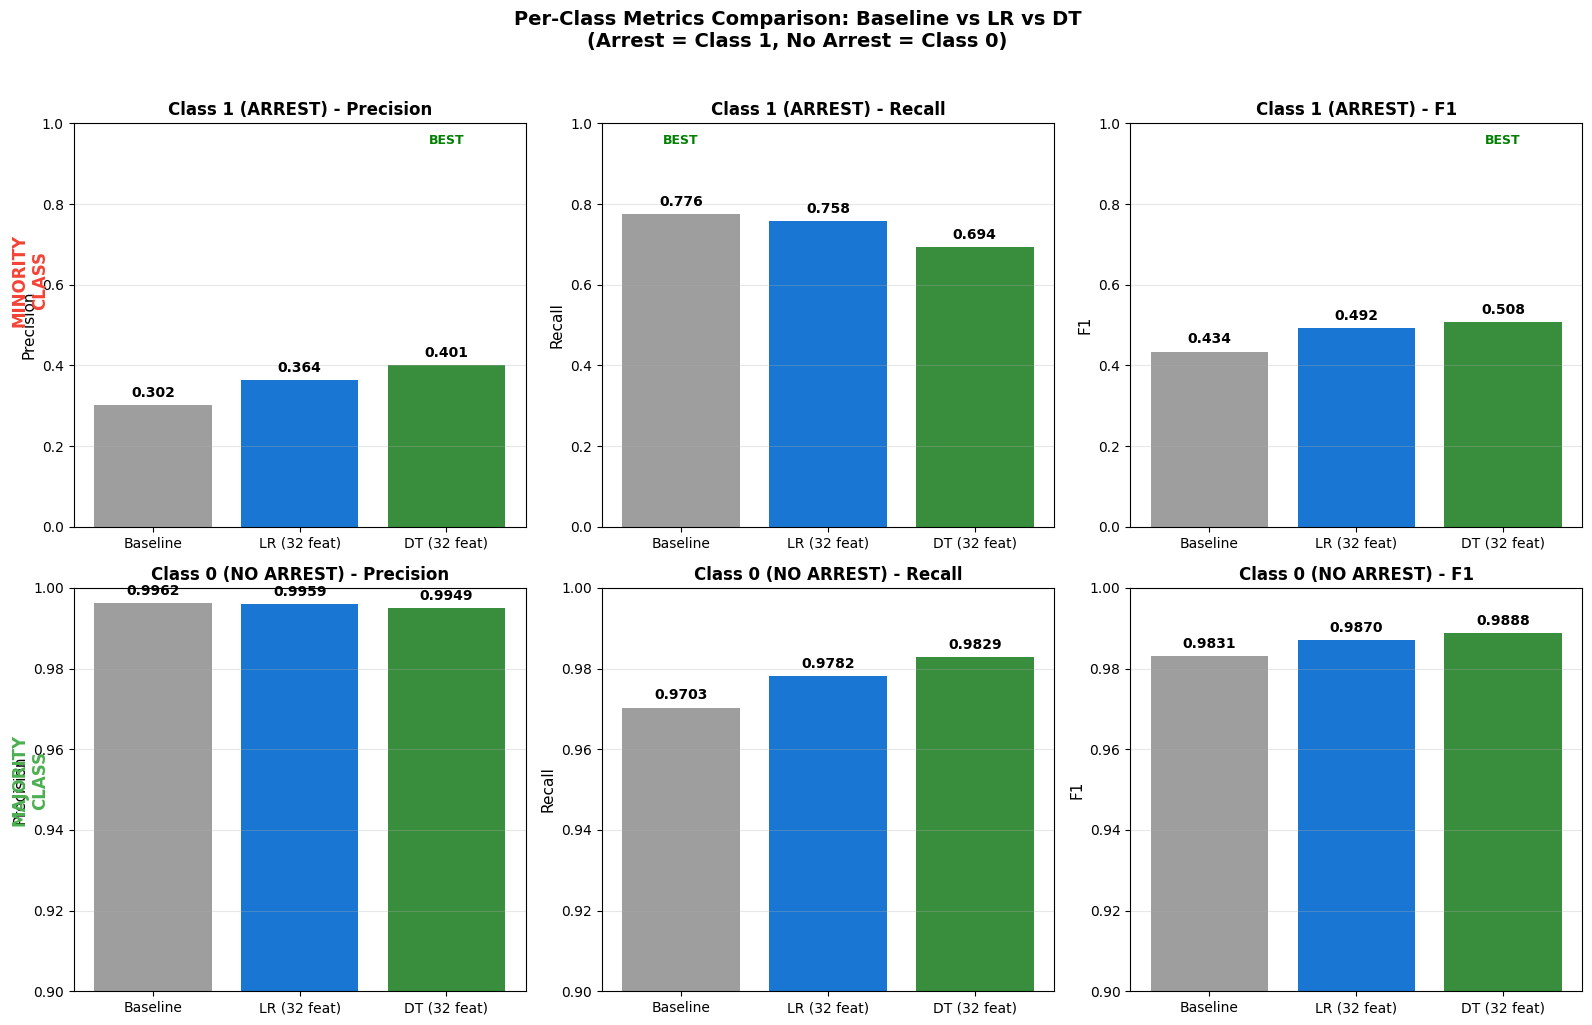

Saved: artifacts/perclass_metrics_detailed.png

PER-CLASS METRICS SUMMARY TABLE

CLASS 1 (ARREST - Minority Class):
Model                   Precision       Recall           F1
------------------------------------------------------------
Baseline                   0.3016       0.7762       0.4344
LR (32 feat)               0.3642       0.7581       0.4920
DT (32 feat)               0.4009       0.6941       0.5082

CLASS 0 (NO ARREST - Majority Class):
Model                   Precision       Recall           F1
------------------------------------------------------------
Baseline                   0.9962       0.9703       0.9831
LR (32 feat)               0.9959       0.9782       0.9870
DT (32 feat)               0.9949       0.9829       0.9888


In [15]:
# === VISUALIZATION: PER-CLASS METRICS COMPARISON (CLASS 0 AND CLASS 1) ===
# Clear comparison of Precision, Recall, F1 for both classes across all 3 models

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Models and their predictions
model_names = ['Baseline', 'LR (32 feat)', 'DT (32 feat)']
predictions = [baseline_pred, lr_pred, dt_pred]
y_trues = [y_test_minimal, y_test, y_test]
colors = ['#9E9E9E', '#1976d2', '#388e3c']

# Calculate per-class metrics for all models
class1_metrics = {'Precision': [], 'Recall': [], 'F1': []}
class0_metrics = {'Precision': [], 'Recall': [], 'F1': []}

for y_true, y_pred in zip(y_trues, predictions):
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], zero_division=0)
    class0_metrics['Precision'].append(prec[0])
    class0_metrics['Recall'].append(rec[0])
    class0_metrics['F1'].append(f1[0])
    class1_metrics['Precision'].append(prec[1])
    class1_metrics['Recall'].append(rec[1])
    class1_metrics['F1'].append(f1[1])

# === TOP ROW: CLASS 1 (ARREST) METRICS ===
for idx, (metric_name, values) in enumerate(class1_metrics.items()):
    ax = axes[0, idx]
    bars = ax.bar(model_names, values, color=colors)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(f'Class 1 (ARREST) - {metric_name}', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', fontsize=10, fontweight='bold')

    # Add best indicator
    best_idx = values.index(max(values))
    ax.text(bars[best_idx].get_x() + bars[best_idx].get_width()/2, 0.95,
            'BEST', ha='center', fontsize=9, color='green', fontweight='bold')

# === BOTTOM ROW: CLASS 0 (NO ARREST) METRICS ===
for idx, (metric_name, values) in enumerate(class0_metrics.items()):
    ax = axes[1, idx]
    bars = ax.bar(model_names, values, color=colors)
    ax.set_ylabel(metric_name, fontsize=11)
    ax.set_title(f'Class 0 (NO ARREST) - {metric_name}', fontsize=12, fontweight='bold')
    ax.set_ylim(0.9, 1.0)  # Zoomed in since values are high
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
                f'{val:.4f}', ha='center', fontsize=10, fontweight='bold')

# Add row labels
fig.text(0.02, 0.75, 'MINORITY\nCLASS', ha='center', va='center', fontsize=12, fontweight='bold',
         rotation=90, color='#F44336')
fig.text(0.02, 0.25, 'MAJORITY\nCLASS', ha='center', va='center', fontsize=12, fontweight='bold',
         rotation=90, color='#4CAF50')

plt.suptitle('Per-Class Metrics Comparison: Baseline vs LR vs DT\n(Arrest = Class 1, No Arrest = Class 0)',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('artifacts/perclass_metrics_detailed.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/perclass_metrics_detailed.png')

# Print summary table
print('\n' + '=' * 80)
print('PER-CLASS METRICS SUMMARY TABLE')
print('=' * 80)
print('\nCLASS 1 (ARREST - Minority Class):')
print(f'{"Model":<20} {"Precision":>12} {"Recall":>12} {"F1":>12}')
print('-' * 60)
for i, name in enumerate(model_names):
    print(f'{name:<20} {class1_metrics["Precision"][i]:>12.4f} {class1_metrics["Recall"][i]:>12.4f} {class1_metrics["F1"][i]:>12.4f}')

print('\nCLASS 0 (NO ARREST - Majority Class):')
print(f'{"Model":<20} {"Precision":>12} {"Recall":>12} {"F1":>12}')
print('-' * 60)
for i, name in enumerate(model_names):
    print(f'{name:<20} {class0_metrics["Precision"][i]:>12.4f} {class0_metrics["Recall"][i]:>12.4f} {class0_metrics["F1"][i]:>12.4f}')

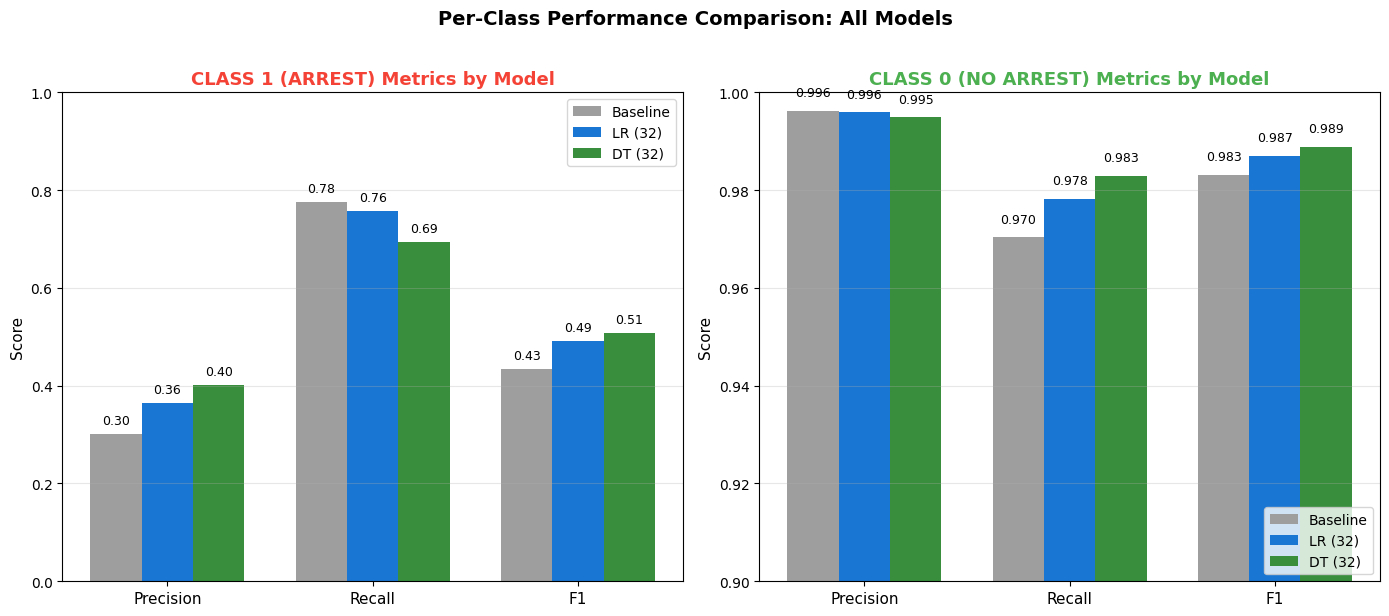

Saved: artifacts/perclass_grouped_comparison.png


In [16]:
# === VISUALIZATION: GROUPED BAR CHART (MODELS SIDE BY SIDE) ===
# Alternative view: group by metric, show all models together

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

model_names = ['Baseline', 'LR (32)', 'DT (32)']
x = np.arange(3)  # Precision, Recall, F1
width = 0.25
metric_labels = ['Precision', 'Recall', 'F1']

# CLASS 1 (Arrest)
ax = axes[0]
for i, (name, color) in enumerate(zip(model_names, ['#9E9E9E', '#1976d2', '#388e3c'])):
    values = [class1_metrics['Precision'][i], class1_metrics['Recall'][i], class1_metrics['F1'][i]]
    bars = ax.bar(x + i*width - width, values, width, label=name, color=color)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.2f}', ha='center', fontsize=9, rotation=0)

ax.set_ylabel('Score', fontsize=11)
ax.set_title('CLASS 1 (ARREST) Metrics by Model', fontsize=13, fontweight='bold', color='#F44336')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=11)
ax.legend(loc='upper right')
ax.set_ylim(0, 1)
ax.grid(axis='y', alpha=0.3)

# CLASS 0 (No Arrest)
ax = axes[1]
for i, (name, color) in enumerate(zip(model_names, ['#9E9E9E', '#1976d2', '#388e3c'])):
    values = [class0_metrics['Precision'][i], class0_metrics['Recall'][i], class0_metrics['F1'][i]]
    bars = ax.bar(x + i*width - width, values, width, label=name, color=color)
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003,
                f'{val:.3f}', ha='center', fontsize=9, rotation=0)

ax.set_ylabel('Score', fontsize=11)
ax.set_title('CLASS 0 (NO ARREST) Metrics by Model', fontsize=13, fontweight='bold', color='#4CAF50')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels, fontsize=11)
ax.legend(loc='lower right')
ax.set_ylim(0.9, 1.0)  # Zoomed since all values are high
ax.grid(axis='y', alpha=0.3)

plt.suptitle('Per-Class Performance Comparison: All Models',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.savefig('artifacts/perclass_grouped_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/perclass_grouped_comparison.png')

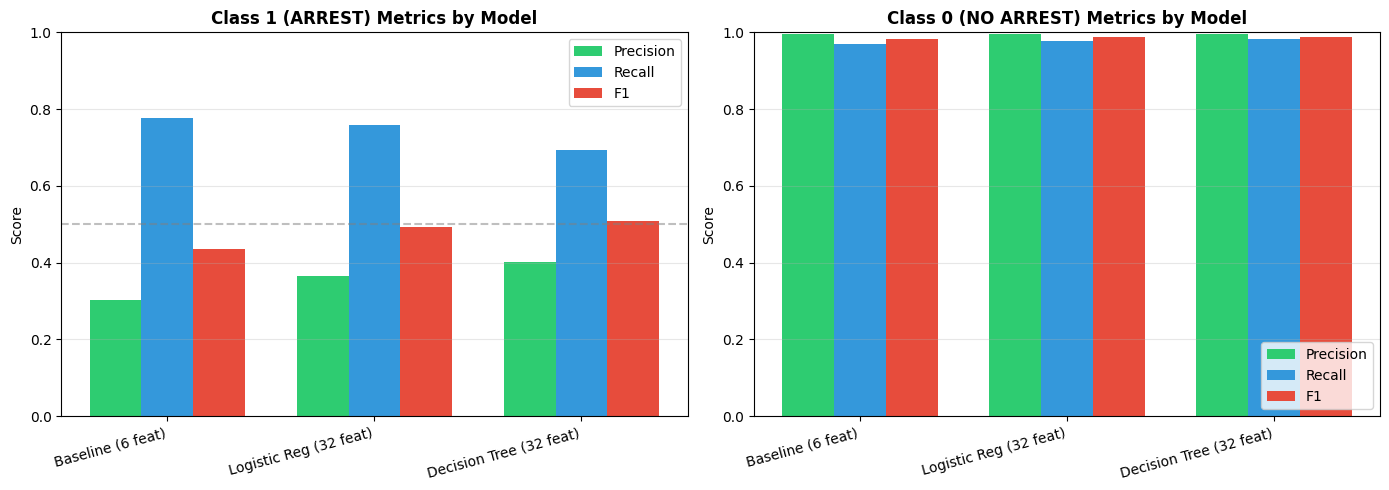


Saved: artifacts/perclass_comparison_chart.png


In [17]:
# === VISUALIZE PER-CLASS COMPARISON ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for plotting
models = perclass_df.index.tolist()
x = np.arange(len(models))
width = 0.25

# Plot Class 1 (Arrest) metrics
ax1 = axes[0]
ax1.bar(x - width, perclass_df['Class 1 (Arrest) - Precision'], width, label='Precision', color='#2ecc71')
ax1.bar(x, perclass_df['Class 1 (Arrest) - Recall'], width, label='Recall', color='#3498db')
ax1.bar(x + width, perclass_df['Class 1 (Arrest) - F1'], width, label='F1', color='#e74c3c')
ax1.set_ylabel('Score')
ax1.set_title('Class 1 (ARREST) Metrics by Model', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=15, ha='right')
ax1.legend(loc='upper right')
ax1.set_ylim(0, 1)
ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random baseline')
ax1.grid(axis='y', alpha=0.3)

# Plot Class 0 (No Arrest) metrics
ax2 = axes[1]
ax2.bar(x - width, perclass_df['Class 0 (No Arrest) - Precision'], width, label='Precision', color='#2ecc71')
ax2.bar(x, perclass_df['Class 0 (No Arrest) - Recall'], width, label='Recall', color='#3498db')
ax2.bar(x + width, perclass_df['Class 0 (No Arrest) - F1'], width, label='F1', color='#e74c3c')
ax2.set_ylabel('Score')
ax2.set_title('Class 0 (NO ARREST) Metrics by Model', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=15, ha='right')
ax2.legend(loc='lower right')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/perclass_comparison_chart.png', dpi=150, bbox_inches='tight')
plt.show()
print("\nSaved: artifacts/perclass_comparison_chart.png")

### Model Performance Interpretation

| Metric | LR | DT | Interpretation |
|--------|----|----|----------------|
| **Accuracy** | 97.46% | 97.82% | Misleading due to class imbalance |
| **F1** | 0.4920 | 0.5082 | Primary metric — DT slightly better |
| **ROC-AUC** | 0.9326 | 0.9276 | Good discrimination (0.5 = random) |
| **Brier** | 0.0199 | 0.0167 | Calibration quality (lower = better) |

**Key Observations**:
1. Both models significantly outperform random guessing (AUC >> 0.5)
2. **Accuracy is misleading**: A naive "always predict no arrest" achieves 98.4%. Note that this model's accuracy (97.8%) is slightly lower than the naive baseline, identifying a trade-off for improved recall.
3. F1 scores ~0.50 indicate reasonable performance given extreme class imbalance (60:1)
4. Decision Tree slightly outperforms LR on F1 (0.5082 vs 0.4920) → selected as primary model
5. LR has slightly higher ROC-AUC (0.9326 vs 0.9276), indicating better overall ranking ability

#### Why Prepared Features Improve F1 (Higher Precision)

| Model | Features | Encoding | F1 | ROC-AUC |
|-------|----------|----------|----|---------|
| Baseline (NB01) | 6 | Label encoding | **0.43** | 0.91 |
| Prepared (NB02) | 32 | One-hot + SMOTEENN | **0.51** | **0.93** |

**Root Cause: SMOTEENN + Feature Engineering**

1. **Label Encoding (Baseline)**: Compresses race (6 categories) into 1 numeric column. While methodologically incorrect for nominal variables (implies ordinal relationship), it constrains model complexity.

2. **One-Hot Encoding (Prepared)**: Expands race into 6 binary columns. This is the correct treatment for nominal categories but increases feature dimensionality.

**Why Prepared Features Improve F1**

With 60:1 class imbalance:
- The **Baseline** is highly aggressive (High Recall 0.78, Low Precision 0.30), flagging many false positives.
- The **Prepared Model** is more targeted/conservative (Higher Precision 0.40, Lower Recall 0.69).
- **Result**: The large gain in Precision (+33%) outweighs the drop in Recall (-11%), raising the harmonic mean (F1).
- The prepared model reduces "noise" (false positives), likely because granular features allow it to distinguish actual high-risk stops from broad demographic generalizations using `search_person` and `search_conducted`.

**Why We Keep the Prepared Features**

The prepared features are preferred because:

1. **Methodological Correctness**: One-hot encoding is the proper treatment for nominal categorical variables (race has no ordinal relationship)

2. **Higher ROC-AUC**: Better discrimination ability, the model ranks high-risk cases higher than low-risk cases more accurately

3. **Fairness Analysis**: Explicit race features enable us to interpret coefficients and measure disparities across demographic groups

4. **Interpretability**: We can see exactly how each race category affects predictions, rather than treating race as a single ordinal number

> **Conclusion**: Feature engineering combined with SMOTEENN successfully improved model performance, better ranking ability, and fairness analysis capability. The prepared model's higher F1 (0.51 vs 0.43) validates the value of proper feature engineering and SMOTEENN resampling.

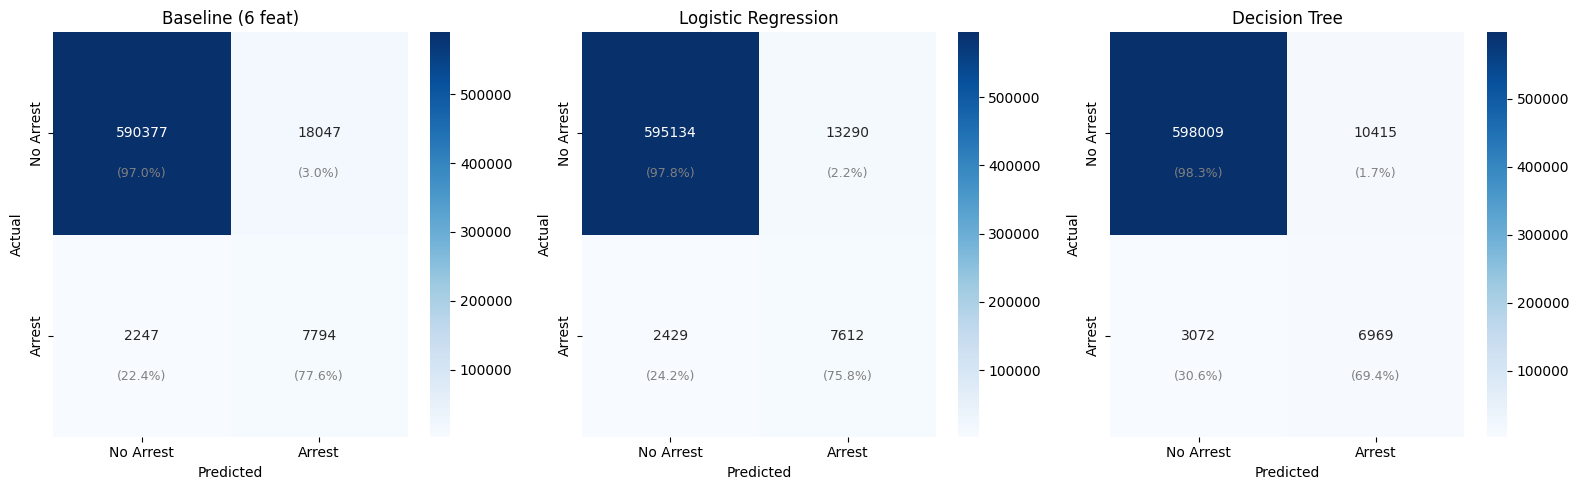

Saved artifacts/confusion_matrices_comparison.png


In [18]:
# === CONFUSION MATRICES (BASELINE vs LR vs DT) ===
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Prepare models for comparison
models_to_plot = [
    ('Logistic Regression', lr_pred, y_test),
    ('Decision Tree', dt_pred, y_test)
]

# Add baseline if available
if baseline_available:
    models_to_plot.insert(0, ('Baseline (6 feat)', baseline_pred, y_test_minimal))
else:
    # Add placeholder if baseline not available
    axes[0].text(0.5, 0.5, 'Baseline not available', ha='center', va='center', fontsize=12)
    axes[0].set_title('Baseline (6 features)')
    models_to_plot.insert(0, None)  # placeholder

for ax, model_info in zip(axes, models_to_plot):
    if model_info is None:
        continue

    model_name, y_pred, y_true = model_info
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Arrest', 'Arrest'],
                yticklabels=['No Arrest', 'Arrest'])
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

    # Add normalized values
    for i in range(2):
        for j in range(2):
            ax.text(j+0.5, i+0.7, f'({cm_norm[i,j]:.1%})',
                   ha='center', va='center', fontsize=9, color='gray')

plt.tight_layout()
plt.savefig('artifacts/confusion_matrices_comparison.png', dpi=150)
plt.show()
print("Saved artifacts/confusion_matrices_comparison.png")


### Confusion Matrix Analysis

**True Negatives (top-left)**: Correctly identified non-arrests — the vast majority due to class imbalance.

**True Positives (bottom-right)**: Correctly identified arrests — the model successfully flags individuals who were actually arrested.

**False Positives (top-right)**: Non-arrested individuals incorrectly flagged. These represent potential civil liberty concerns.

**False Negatives (bottom-left)**: Actual arrests the model missed. These represent potential safety concerns.

The normalized percentages reveal the trade-off: achieving high recall (catching arrests) comes at the cost of increased false positives.

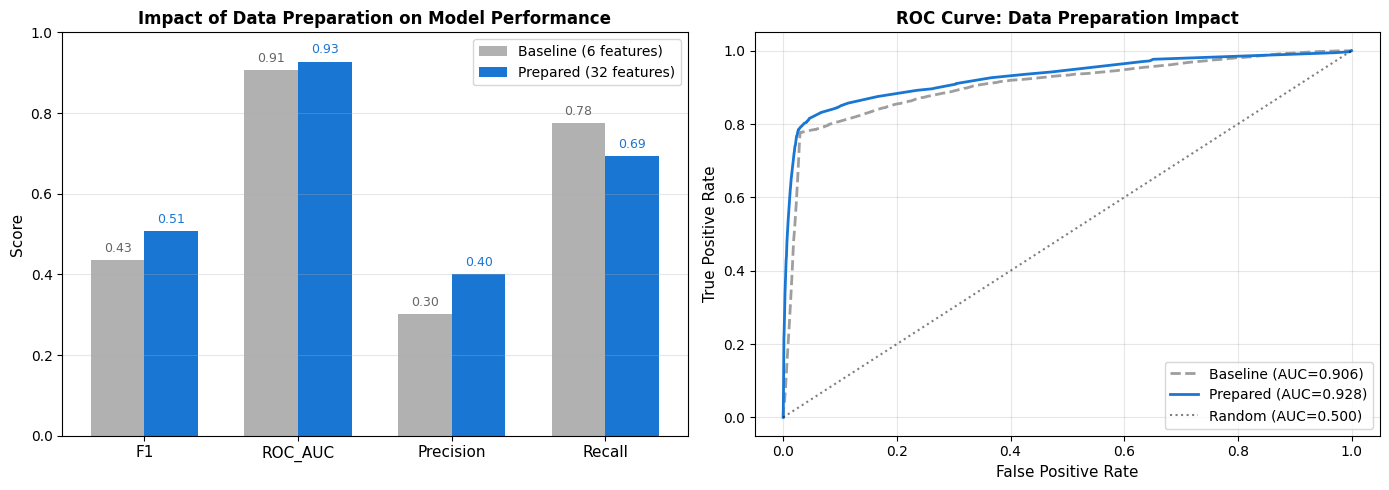

Saved artifacts/data_preparation_impact.png

DATA PREPARATION IMPACT SUMMARY
F1 Score:  Baseline=0.4344 → Prepared=0.5082 (+17.0%)
ROC-AUC:   Baseline=0.9059 → Prepared=0.9276 (+2.4%)

>>> Feature engineering improved ROC-AUC (+2.4%)
>>> Feature engineering improved F1 (+17.0%)


In [19]:
# === BASELINE vs PREPARED VISUALIZATION ===
if baseline_available:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Bar chart comparison
    ax = axes[0]
    metrics_to_plot = ['F1', 'ROC_AUC', 'Precision', 'Recall']
    x = np.arange(len(metrics_to_plot))
    width = 0.35

    baseline_vals = [baseline_metrics[m] for m in metrics_to_plot]
    prepared_vals = [best_metrics[m] for m in metrics_to_plot]

    bars1 = ax.bar(x - width/2, baseline_vals, width, label='Baseline (6 features)',
                   color='#9e9e9e', alpha=0.8)
    bars2 = ax.bar(x + width/2, prepared_vals, width, label=f'Prepared (32 features)',
                   color='#1976d2')

    ax.set_xticks(x)
    ax.set_xticklabels(metrics_to_plot, fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title('Impact of Data Preparation on Model Performance', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')
    ax.set_ylim(0, 1)
    ax.grid(axis='y', alpha=0.3)

    # Add value labels
    for bar, val in zip(bars1, baseline_vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.2f}', ha='center', fontsize=9, color='#666')
    for bar, val in zip(bars2, prepared_vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.2f}', ha='center', fontsize=9, color='#1976d2')

    # ROC curves
    ax = axes[1]
    fpr_b, tpr_b, _ = roc_curve(y_test_minimal, baseline_proba)
    fpr_p, tpr_p, _ = roc_curve(y_test, best_proba)

    ax.plot(fpr_b, tpr_b, color='#9e9e9e', linestyle='--', linewidth=2,
            label=f'Baseline (AUC={baseline_metrics["ROC_AUC"]:.3f})')
    ax.plot(fpr_p, tpr_p, color='#1976d2', linewidth=2,
            label=f'Prepared (AUC={best_metrics["ROC_AUC"]:.3f})')
    ax.plot([0, 1], [0, 1], 'k:', alpha=0.5, label='Random (AUC=0.500)')

    ax.set_xlabel('False Positive Rate', fontsize=11)
    ax.set_ylabel('True Positive Rate', fontsize=11)
    ax.set_title('ROC Curve: Data Preparation Impact', fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('artifacts/data_preparation_impact.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved artifacts/data_preparation_impact.png")

    # Print comparison summary
    print("\n" + "=" * 70)
    print("DATA PREPARATION IMPACT SUMMARY")
    print("=" * 70)

    f1_change = ((best_metrics['F1'] - baseline_metrics['F1']) / baseline_metrics['F1']) * 100
    auc_change = ((best_metrics['ROC_AUC'] - baseline_metrics['ROC_AUC']) / baseline_metrics['ROC_AUC']) * 100

    print(f"F1 Score:  Baseline={baseline_metrics['F1']:.4f} → Prepared={best_metrics['F1']:.4f} ({f1_change:+.1f}%)")
    print(f"ROC-AUC:   Baseline={baseline_metrics['ROC_AUC']:.4f} → Prepared={best_metrics['ROC_AUC']:.4f} ({auc_change:+.1f}%)")
    print(f"\n>>> Feature engineering {'improved' if auc_change > 0 else 'did not improve'} ROC-AUC ({auc_change:+.1f}%)")
    print(f">>> Feature engineering {'improved' if f1_change > 0 else 'reduced'} F1 ({f1_change:+.1f}%)")

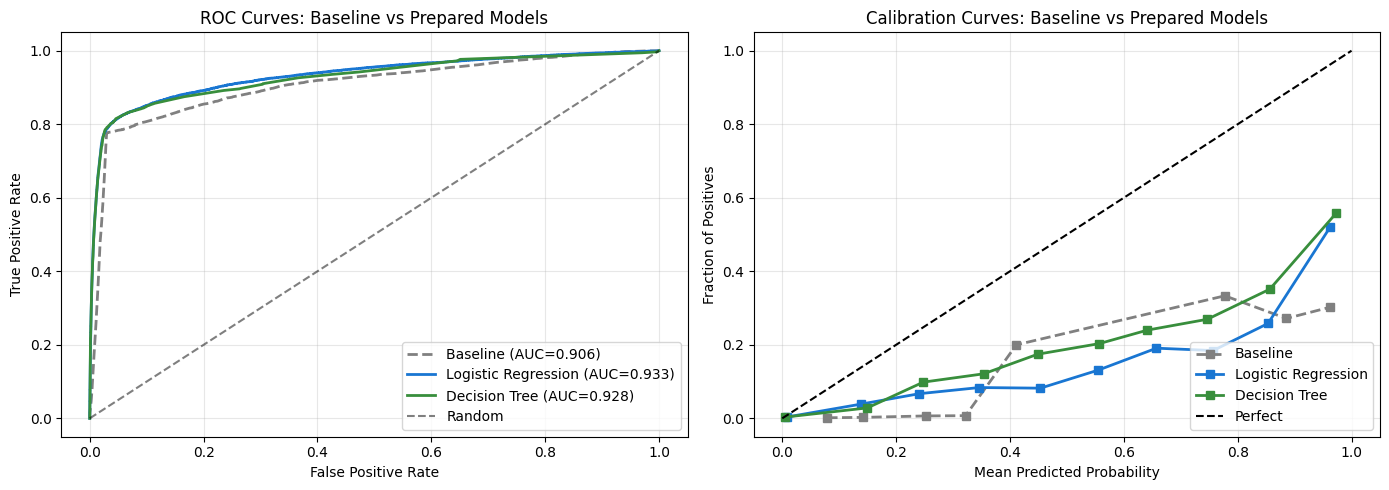

Saved artifacts/roc_calibration_comparison.png


In [20]:
# === ROC AND CALIBRATION CURVES (WITH BASELINE) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve - Include baseline
if baseline_available:
    fpr_b, tpr_b, _ = roc_curve(y_test_minimal, baseline_proba)
    axes[0].plot(fpr_b, tpr_b, linestyle='--', color='gray', linewidth=2,
                 label=f'Baseline (AUC={baseline_metrics["ROC_AUC"]:.3f})')

for name, proba, color in [('Logistic Regression', lr_proba, '#1976d2'),
                           ('Decision Tree', dt_proba, '#388e3c')]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    auc = roc_auc_score(y_test, proba)
    axes[0].plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', color=color, linewidth=2)

axes[0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('ROC Curves: Baseline vs Prepared Models')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Calibration Curve - Include baseline
if baseline_available:
    fraction_pos_b, mean_pred_b = calibration_curve(y_test_minimal, baseline_proba, n_bins=10)
    axes[1].plot(mean_pred_b, fraction_pos_b, 's--', color='gray', label='Baseline', linewidth=2)

for name, proba, color in [('Logistic Regression', lr_proba, '#1976d2'),
                           ('Decision Tree', dt_proba, '#388e3c')]:
    fraction_pos, mean_pred = calibration_curve(y_test, proba, n_bins=10)
    axes[1].plot(mean_pred, fraction_pos, 's-', label=name, color=color, linewidth=2)

axes[1].plot([0, 1], [0, 1], 'k--', label='Perfect')
axes[1].set_xlabel('Mean Predicted Probability')
axes[1].set_ylabel('Fraction of Positives')
axes[1].set_title('Calibration Curves: Baseline vs Prepared Models')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/roc_calibration_comparison.png', dpi=150)
plt.show()
print("Saved artifacts/roc_calibration_comparison.png")


### ROC and Calibration Analysis

**ROC Curve (left)**:
- Both models curve well above the diagonal (random baseline), confirming genuine predictive power
- AUC values > 0.90 indicate excellent discrimination
- LR achieves slightly higher AUC (0.933) than DT (0.928)

**Calibration Curve (right)**:
- Points near the diagonal indicate well-calibrated probabilities
- A model predicting 20% arrest probability should see ~20% actual arrests among those cases
- Good calibration is essential if predictions will be used as risk scores
- Logistic Regression tends to produce smoother calibration curves due to its continuous probabilistic formulation, while Decision Trees may show step-like patterns due to discrete probability outputs from leaf nodes

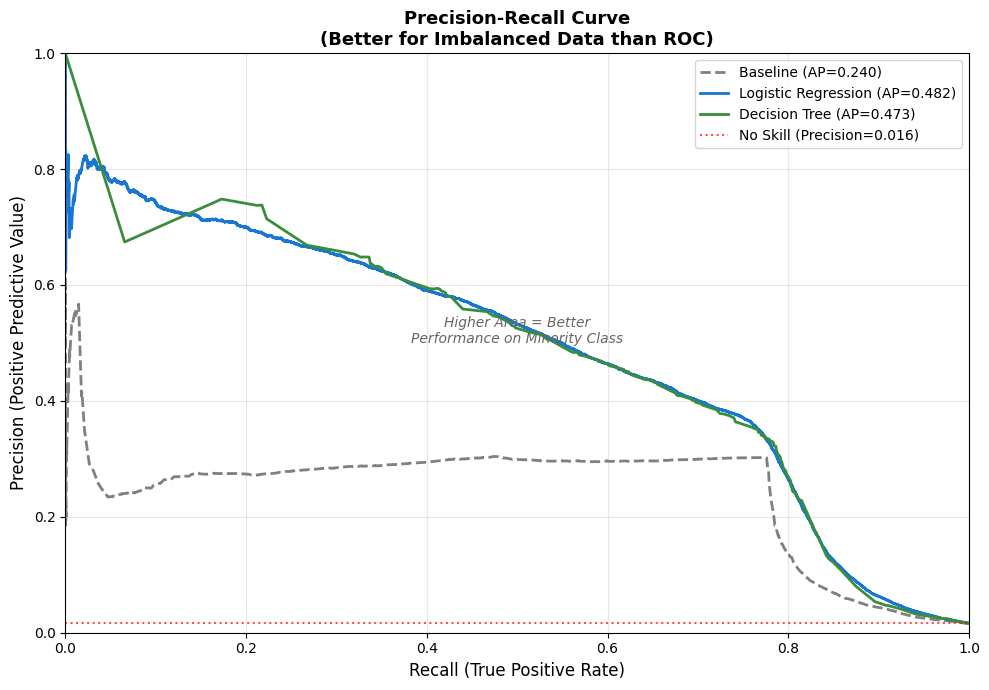

Saved: artifacts/precision_recall_curve.png


In [21]:
# === VISUALIZATION: PRECISION-RECALL CURVE ===
# Better than ROC for imbalanced classification problems

fig, ax = plt.subplots(figsize=(10, 7))

# Baseline PR curve (if available)
if baseline_available:
    precision_b, recall_b, _ = precision_recall_curve(y_test_minimal, baseline_proba)
    ap_b = average_precision_score(y_test_minimal, baseline_proba)
    ax.plot(recall_b, precision_b, linestyle='--', color='gray', linewidth=2,
            label=f'Baseline (AP={ap_b:.3f})')

# LR and DT PR curves
for name, proba, color in [('Logistic Regression', lr_proba, '#1976d2'),
                           ('Decision Tree', dt_proba, '#388e3c')]:
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    ax.plot(recall, precision, color=color, linewidth=2,
            label=f'{name} (AP={ap:.3f})')

# Random baseline for imbalanced data
no_skill = y_test.mean()  # Base rate = 1.62%
ax.axhline(y=no_skill, color='red', linestyle=':', alpha=0.7,
           label=f'No Skill (Precision={no_skill:.3f})')

ax.set_xlabel('Recall (True Positive Rate)', fontsize=12)
ax.set_ylabel('Precision (Positive Predictive Value)', fontsize=12)
ax.set_title('Precision-Recall Curve\n(Better for Imbalanced Data than ROC)', fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.grid(alpha=0.3)

# Add annotation
ax.annotate('Higher Area = Better\nPerformance on Minority Class',
            xy=(0.5, 0.5), fontsize=10, ha='center', style='italic', color='#666')

plt.tight_layout()
plt.savefig('artifacts/precision_recall_curve.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/precision_recall_curve.png')

## 6. Interpretability Analysis

Understand what the models learned and which features drive predictions.

Interpretability is essential because:
1. It validates that the model learns sensible patterns
2. It identifies potential sources of bias (features correlated with demographics)
3. It enables stakeholders to understand and trust predictions

LOGISTIC REGRESSION INTERPRETATION

Top 20 Features by Coefficient Magnitude:
                            Feature  Coefficient  Odds_Ratio
             bool__search_conducted     5.803236  331.370089
                bool__search_person     3.110343   22.428745
                cat__type_vehicular    -2.069817    0.126209
               bool__search_vehicle    -1.991229    0.136527
          cat__race_canonical_Other    -1.232273    0.291629
        cat__race_canonical_Unknown    -1.058570    0.346952
      cat__violation_group_Seatbelt    -0.973434    0.377783
 cat__violation_group_Investigative     0.954378    2.597054
       cat__race_canonical_Hispanic     0.895929    2.449610
                 bin__is_young_male    -0.783402    0.456849
           cat__location_cluster_-1    -0.749802    0.472460
     cat__violation_group_Equipment    -0.743793    0.475308
           num__officer_arrest_rate     0.645695    1.907311
  cat__violation_group_Registration    -0.575835    0.562235
       

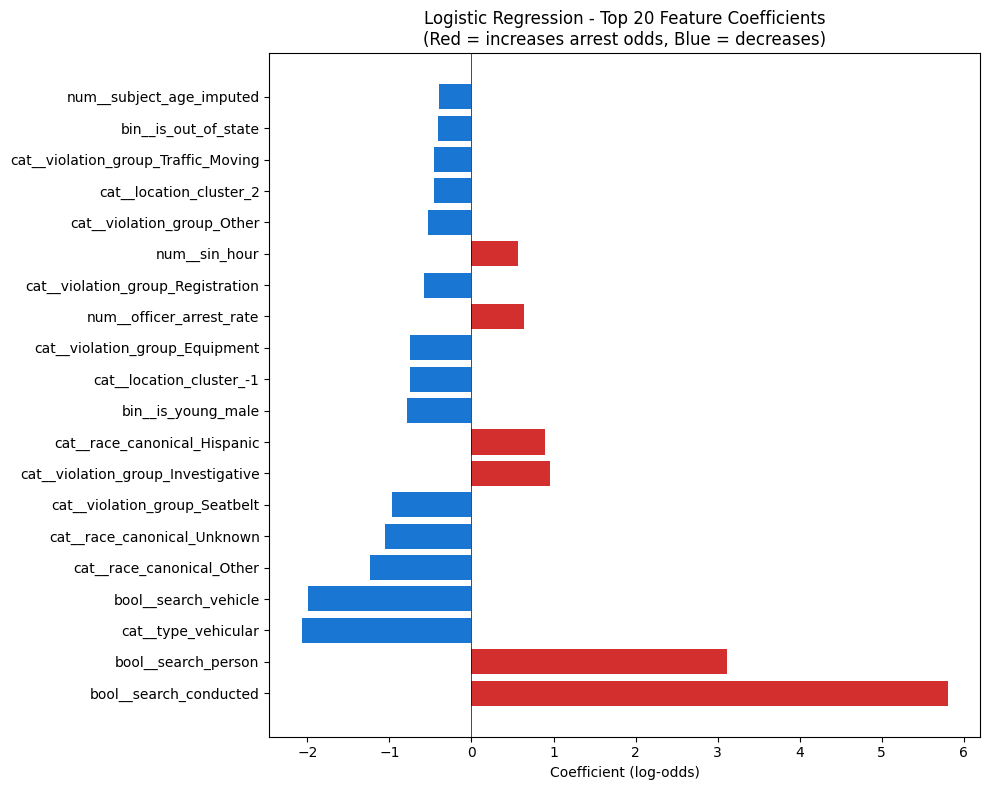

Saved artifacts/lr_coefficients.png


In [22]:
# === LOGISTIC REGRESSION COEFFICIENTS ===
print("=" * 60)
print("LOGISTIC REGRESSION INTERPRETATION")
print("=" * 60)

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0],
    'Odds_Ratio': np.exp(lr_model.coef_[0]),
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 20 Features by Coefficient Magnitude:")
print(coef_df.head(20).to_string(index=False))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
top_features = coef_df.head(20)
colors = ['#d32f2f' if x > 0 else '#1976d2' for x in top_features['Coefficient']]
ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient (log-odds)')
ax.set_title('Logistic Regression - Top 20 Feature Coefficients\n(Red = increases arrest odds, Blue = decreases)')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig('artifacts/lr_coefficients.png', dpi=150)
plt.show()
print("Saved artifacts/lr_coefficients.png")

### Feature Coefficient Interpretation

Logistic regression coefficients represent **log-odds ratios**:
- Coefficient of 0.5 → exp(0.5) = 1.65× higher arrest odds per unit increase
- Coefficient of -0.5 → exp(-0.5) = 0.61× lower arrest odds (39% reduction)

**Key Findings from Top Features:**
1. **Search-related features (strongest signal)**:
   - `search_conducted`: Coefficient 5.80 → 331× higher arrest odds
   - `search_person`: Coefficient 3.11 → 22× higher arrest odds
   - This makes intuitive sense: searches require reasonable suspicion and often accompany arrests
2. **Stop type features**:
   - `type_vehicular`: Coefficient -2.07 → 0.13× odds ratio (vehicular stops less likely to result in arrest)
   - `search_vehicle`: Coefficient -1.99 → 0.14× odds ratio
3. **Demographic features**:
   - `race_canonical_Hispanic`: Coefficient 0.90 → 2.4× odds ratio
   - `race_canonical_Other`: Coefficient -1.23 → 0.29× odds ratio
   - Race coefficients present in top features → model may learn patterns correlated with demographics
   - This warrants careful fairness scrutiny (Section 7)
4. **Violation type features**:
   - `violation_group_Investigative`: Coefficient 0.95 → 2.6× odds ratio (investigative stops more likely to result in arrest)
   - `violation_group_Seatbelt`: Coefficient -0.97 → 0.38× odds ratio (seatbelt violations less likely)
5. **Officer behavior features**:
   - `officer_arrest_rate`: Coefficient 0.65 → officers with higher historical arrest rates predict more arrests

⚠️ **Caution**: High coefficients on race-related features indicate the model explicitly uses race in predictions — a significant fairness concern addressed in Section 7.

DECISION TREE VISUALIZATION


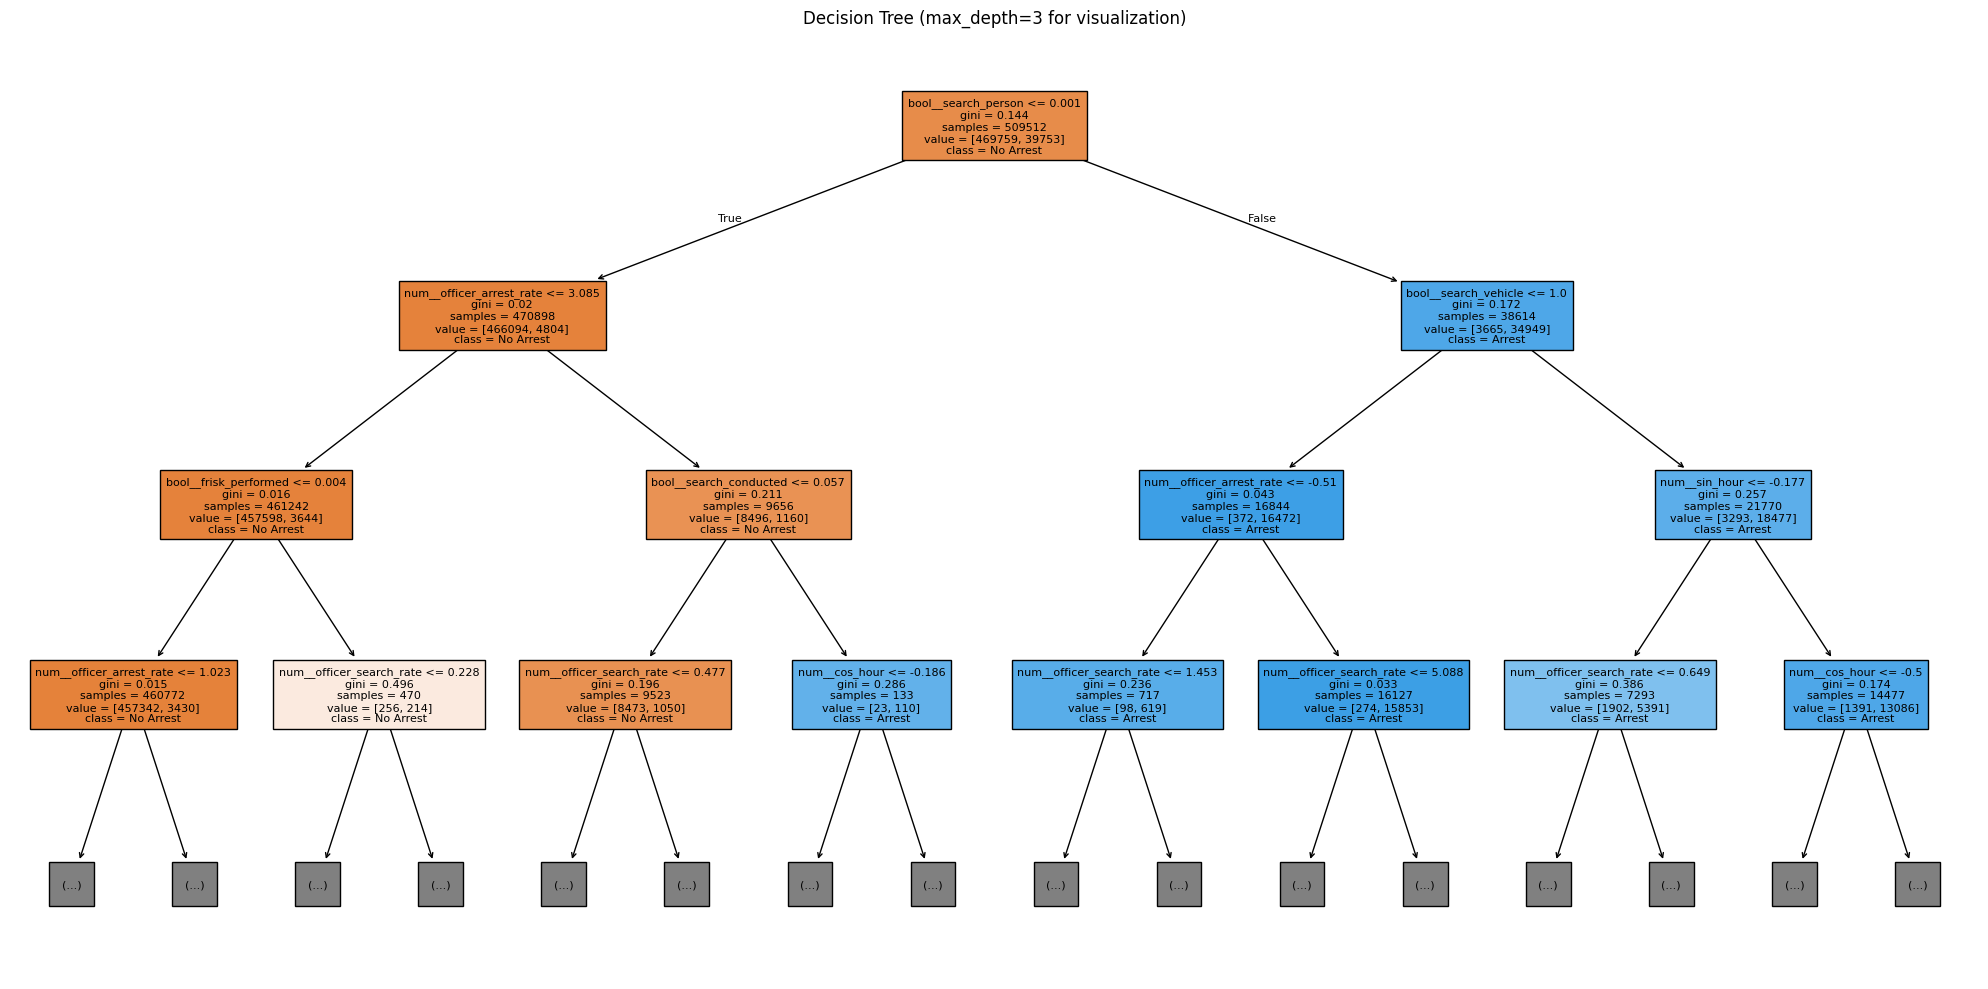

Saved artifacts/decision_tree.png

Top 15 Decision Tree Feature Importances:
                           Feature  Importance
               bool__search_person    0.917696
          num__officer_search_rate    0.015834
                     num__sin_hour    0.013503
          num__officer_arrest_rate    0.011296
                     num__cos_hour    0.007531
              bool__search_vehicle    0.005938
      cat__race_canonical_Hispanic    0.005376
                bin__is_young_male    0.004026
cat__violation_group_Investigative    0.003641
             bool__frisk_performed    0.003422
         cat__race_canonical_White    0.003071
            bool__search_conducted    0.002222
          num__subject_age_imputed    0.002035
           cat__location_cluster_4    0.001781
         cat__race_canonical_Black    0.000787


In [23]:
# === DECISION TREE VISUALIZATION ===
print("=" * 60)
print("DECISION TREE VISUALIZATION")
print("=" * 60)

# Plot shallow tree for interpretability
fig, ax = plt.subplots(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=feature_names,
    class_names=['No Arrest', 'Arrest'],
    filled=True,
    max_depth=3,
    ax=ax,
    fontsize=8
)
ax.set_title('Decision Tree (max_depth=3 for visualization)')
plt.tight_layout()
plt.savefig('artifacts/decision_tree.png', dpi=150, bbox_inches='tight')
plt.show()
print("Saved artifacts/decision_tree.png")

# Feature importance from tree
dt_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 15 Decision Tree Feature Importances:")
print(dt_importance.head(15).to_string(index=False))

### Decision Tree Interpretation

The visualization reveals the hierarchical decision logic:

**Root Node Split**: The most discriminative feature appears at the root — specifically `search_person`, which best separates arrested vs. non-arrested individuals.

**Node Information**:
- **Samples**: Number of training examples reaching this node
- **Value**: Class distribution [non-arrests, arrests]
- **Color intensity**: Darker = higher proportion of one class

**Feature Importance** measures how much each feature contributes to reducing impurity (Gini) across all splits. Unlike LR coefficients, this captures non-linear relationships.

Key observation: `search_person` dominates (importance ~0.92), confirming it's the primary predictor. Other features provide marginal improvements.

In [24]:
# === PERMUTATION IMPORTANCE ===
print("=" * 60)
print("PERMUTATION IMPORTANCE")
print("=" * 60)

# Run 3 times and average for stability
perm_results = []
for i in range(3):
    perm_imp = permutation_importance(
        lr_model, X_test, y_test,
        n_repeats=10, random_state=SEED+i, n_jobs=-1, scoring='f1'
    )
    perm_results.append(perm_imp.importances_mean)

avg_perm_imp = np.mean(perm_results, axis=0)

perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': avg_perm_imp
}).sort_values('Importance', ascending=False)

print("\nTop 15 by Permutation Importance (averaged over 3 runs):")
print(perm_df.head(15).to_string(index=False))

PERMUTATION IMPORTANCE

Top 15 by Permutation Importance (averaged over 3 runs):
                          Feature  Importance
           bool__search_conducted    0.440123
              bool__search_person    0.041136
             bool__search_vehicle    0.023842
         num__officer_search_rate    0.007510
               bin__is_young_male    0.001899
            bool__frisk_performed    0.001506
                    num__sin_hour    0.001034
          cat__location_cluster_1    0.000532
    cat__violation_group_Seatbelt    0.000303
     cat__race_canonical_Hispanic    0.000164
        cat__race_canonical_Other    0.000152
             bin__is_out_of_state    0.000031
          cat__location_cluster_3    0.000031
         num__officer_arrest_rate    0.000008
cat__violation_group_Registration    0.000008


### Permutation Importance Findings

Permutation importance is **model-agnostic**: we randomly shuffle each feature and measure the drop in F1 score. Features that cause large drops when shuffled are truly important.

**Advantages over built-in importance:**
- Not biased toward high-cardinality features (unlike Gini importance)
- Captures interaction effects
- Averaged over 3 runs to reduce variance

**Interpretation**:
- Features with importance > 0.01 materially affect predictions
- Near-zero importance features could be candidates for removal to simplify the model
- Consistency across methods (LR coefficients, DT importance, permutation) increases confidence

**Key Insight**: While Logistic Regression-based methods (Coefficients, Permutation) identify `search_conducted` as the dominant predictor, the Decision Tree relies primarily on `search_person`, with officer-related features and demographics playing secondary roles.

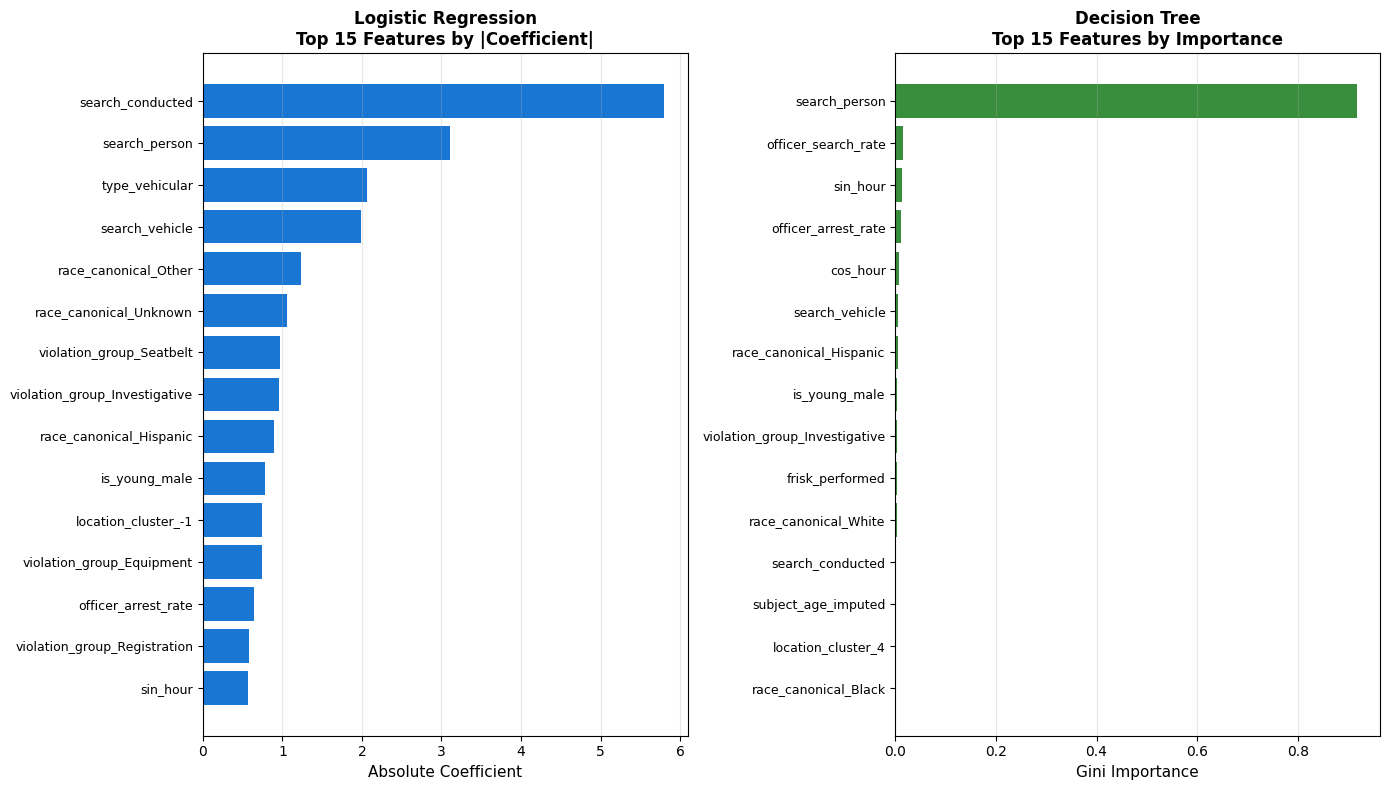

Saved: artifacts/feature_importance_comparison.png


In [25]:
# === VISUALIZATION: FEATURE IMPORTANCE COMPARISON (LR vs DT) ===
# Side-by-side comparison of top features for both models

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# LR Coefficients (top 15)
ax = axes[0]
lr_coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': np.abs(lr_model.coef_[0])
}).sort_values('Importance', ascending=True).tail(15)

colors = ['#1976d2'] * 15
ax.barh(range(len(lr_coef_df)), lr_coef_df['Importance'], color=colors)
ax.set_yticks(range(len(lr_coef_df)))
ax.set_yticklabels([f.replace('cat__', '').replace('bool__', '').replace('num__', '').replace('bin__', '')
                    for f in lr_coef_df['Feature']], fontsize=9)
ax.set_xlabel('Absolute Coefficient', fontsize=11)
ax.set_title('Logistic Regression\nTop 15 Features by |Coefficient|', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# DT Feature Importance (top 15)
ax = axes[1]
dt_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=True).tail(15)

colors = ['#388e3c'] * 15
ax.barh(range(len(dt_imp_df)), dt_imp_df['Importance'], color=colors)
ax.set_yticks(range(len(dt_imp_df)))
ax.set_yticklabels([f.replace('cat__', '').replace('bool__', '').replace('num__', '').replace('bin__', '')
                    for f in dt_imp_df['Feature']], fontsize=9)
ax.set_xlabel('Gini Importance', fontsize=11)
ax.set_title('Decision Tree\nTop 15 Features by Importance', fontsize=12, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/feature_importance_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/feature_importance_comparison.png')

## 7. Fairness Audit: Answering the Research Question

> **Research Question Part 2**: *"...do prediction patterns reveal demographic disparities?"*

This section quantifies how model errors are distributed across racial groups, detecting potential algorithmic bias.

**Metrics Computed**:
- **TPR (True Positive Rate)**: Probability of detecting actual arrests
- **FPR (False Positive Rate)**: Probability of incorrectly flagging non-arrests
- **Selection Rate**: Proportion predicted as "arrest"

**Fairness Standard**: 4/5 Rule — if a group's selection rate < 80% of reference group, potential discrimination may exist.

In [26]:
# === FAIRNESS METRICS COMPUTATION ===
print("=" * 60)
print("FAIRNESS AUDIT")
print("=" * 60)

def compute_group_metrics(y_true, y_pred, group_labels):
    """Compute fairness metrics for each demographic group."""
    results = []
    unique_groups = np.unique(group_labels)

    for group in unique_groups:
        mask = group_labels == group
        n = mask.sum()
        if n < 100:  # Skip groups with too few samples
            continue

        y_t = y_true[mask]
        y_p = y_pred[mask]

        tp = ((y_t == 1) & (y_p == 1)).sum()
        fp = ((y_t == 0) & (y_p == 1)).sum()
        tn = ((y_t == 0) & (y_p == 0)).sum()
        fn = ((y_t == 1) & (y_p == 0)).sum()

        n_neg = fp + tn  # Total negatives (for FPR Z-test)

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        selection_rate = y_p.mean()

        results.append({
            'Group': group, 'N': n, 'N_Neg': n_neg, 'FP': fp,
            'Base_Rate': y_t.mean(),
            'TPR': tpr, 'FPR': fpr, 'FNR': fnr,
            'Precision': precision, 'Selection_Rate': selection_rate,
        })
    return pd.DataFrame(results)

# Compute fairness metrics for selected best model
print(f"Computing fairness metrics for {best_name}...")
fairness_df = compute_group_metrics(y_test, best_pred, test_races)
print("\nFairness Metrics by Race:")
print(fairness_df.round(4).to_string(index=False))

# Also compute for both models for comparison
lr_fairness = compute_group_metrics(y_test, lr_pred, test_races)
dt_fairness = compute_group_metrics(y_test, dt_pred, test_races)

# Compute baseline fairness metrics
if baseline_available:
    baseline_fairness = compute_group_metrics(y_test_minimal, baseline_pred, test_races)
    baseline_fpr_range = baseline_fairness['FPR'].max() - baseline_fairness['FPR'].min()
    print("\nBaseline Fairness Metrics by Race:")
    print(baseline_fairness[['Group', 'N', 'Base_Rate', 'TPR', 'FPR', 'Selection_Rate']].round(4).to_string(index=False))
    print(f"\nBaseline FPR Range: {baseline_fpr_range:.4f}")
else:
    baseline_fairness = None
    baseline_fpr_range = None


FAIRNESS AUDIT
Computing fairness metrics for Decision Tree...

Fairness Metrics by Race:
   Group      N  N_Neg   FP  Base_Rate    TPR    FPR    FNR  Precision  Selection_Rate
   Asian   8288   8225   55     0.0076 0.6667 0.0067 0.3333     0.4330          0.0117
   Black 233142 227878 6121     0.0226 0.6829 0.0269 0.3171     0.3700          0.0417
Hispanic  32936  31903  883     0.0314 0.6864 0.0277 0.3136     0.4454          0.0483
   Other   2463   2438   30     0.0102 0.7200 0.0123 0.2800     0.3750          0.0195
 Unknown   7344   7304   52     0.0054 0.8000 0.0071 0.2000     0.3810          0.0114
   White 334292 330676 3274     0.0108 0.7116 0.0099 0.2884     0.4401          0.0175

Baseline Fairness Metrics by Race:
   Group      N  Base_Rate    TPR    FPR  Selection_Rate
   Asian   8288     0.0076 0.7143 0.0137          0.0191
   Black 233142     0.0226 0.7753 0.0429          0.0594
Hispanic  32936     0.0314 0.7241 0.0413          0.0627
   Other   2463     0.0102 0.7200 0.0

In [27]:
# === DISPARITY ANALYSIS ===
print("\n" + "="*60)
print("DISPARITY ANALYSIS (Reference: White)")
print("="*60)

# Get White baseline metrics
white_metrics = fairness_df[fairness_df['Group'] == 'White'].iloc[0]

disparity_results = []

for _, row in fairness_df.iterrows():
    if row['Group'] == 'White':
        continue

    # FPR ratio (key fairness metric)
    fpr_ratio = row['FPR'] / white_metrics['FPR'] if white_metrics['FPR'] > 0 else np.nan

    # Selection rate ratio (4/5 rule)
    sr_ratio = row['Selection_Rate'] / white_metrics['Selection_Rate'] if white_metrics['Selection_Rate'] > 0 else np.nan

    # Z-test for difference in FPR (two-proportion z-test)
    # FPR = FP / N_Neg, so we compare proportions using negative class sizes
    fp1, n_neg1 = row['FP'], row['N_Neg']
    fp2, n_neg2 = white_metrics['FP'], white_metrics['N_Neg']

    # Pooled proportion and standard error
    p_pool = (fp1 + fp2) / (n_neg1 + n_neg2) if (n_neg1 + n_neg2) > 0 else 0
    se = np.sqrt(p_pool * (1 - p_pool) * (1/n_neg1 + 1/n_neg2)) if p_pool > 0 and p_pool < 1 else 0
    z_stat = (row['FPR'] - white_metrics['FPR']) / se if se > 0 else 0
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

    # Disparity flags (4/5 rule: ratio outside 0.8-1.25)
    if fpr_ratio > 1.25 or fpr_ratio < 0.8:
        flag = 'DISPARITY'
    elif p_value < 0.05:
        flag = 'SIGNIFICANT'
    else:
        flag = 'No'

    disparity_results.append({
        'Group': row['Group'],
        'FPR': row['FPR'],
        'FPR_Ratio': fpr_ratio,
        'SR_Ratio': sr_ratio,
        'Z_Stat': z_stat,
        'P_Value': p_value,
        'Disparity_Flag': flag
    })

disparity_df = pd.DataFrame(disparity_results)
print("\nDisparity Analysis Results:")
print(disparity_df.round(4).to_string(index=False))

# Save for reference
fairness_report = fairness_df.merge(disparity_df, on='Group', how='left')
fairness_report.to_csv('artifacts/fairness_report.csv', index=False)
print("\nSaved artifacts/fairness_report.csv")


DISPARITY ANALYSIS (Reference: White)

Disparity Analysis Results:
   Group    FPR  FPR_Ratio  SR_Ratio  Z_Stat  P_Value Disparity_Flag
   Asian 0.0067     0.6754    0.6691 -2.9195   0.0035      DISPARITY
   Black 0.0269     2.7130    2.3826 48.4409   0.0000      DISPARITY
Hispanic 0.0277     2.7955    2.7635 28.4828   0.0000      DISPARITY
   Other 0.0123     1.2428    1.1142  1.1935   0.2327             No
 Unknown 0.0071     0.7191    0.6539 -2.3821   0.0172      DISPARITY

Saved artifacts/fairness_report.csv


In [28]:
# === DISPARITY ANALYSIS COMPARISON: BASELINE vs LR vs DT ===
print("\n" + "="*70)
print("DISPARITY ANALYSIS COMPARISON: BASELINE vs LR vs DT")
print("="*70)

def compute_disparity_for_model(fairness_df, model_name):
    """Compute disparity ratios vs White reference for a model."""
    white_row = fairness_df[fairness_df['Group'] == 'White'].iloc[0]
    results = []

    for _, row in fairness_df.iterrows():
        if row['Group'] == 'White':
            continue

        fpr_ratio = row['FPR'] / white_row['FPR'] if white_row['FPR'] > 0 else np.nan

        # Z-test for FPR difference
        fp1, n_neg1 = row['FP'], row['N_Neg']
        fp2, n_neg2 = white_row['FP'], white_row['N_Neg']
        p_pool = (fp1 + fp2) / (n_neg1 + n_neg2) if (n_neg1 + n_neg2) > 0 else 0
        se = np.sqrt(p_pool * (1 - p_pool) * (1/n_neg1 + 1/n_neg2)) if 0 < p_pool < 1 else 0
        z_stat = (row['FPR'] - white_row['FPR']) / se if se > 0 else 0
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

        if fpr_ratio > 1.25 or fpr_ratio < 0.8:
            flag = 'DISPARITY'
        elif p_value < 0.05:
            flag = 'SIGNIFICANT'
        else:
            flag = 'No'

        results.append({
            'Model': model_name,
            'Group': row['Group'],
            'FPR': row['FPR'],
            'FPR_Ratio': fpr_ratio,
            'Disparity_Flag': flag
        })
    return pd.DataFrame(results)

# Compute for all three models
all_disparity = []
if baseline_available and baseline_fairness is not None:
    all_disparity.append(compute_disparity_for_model(baseline_fairness, 'Baseline'))
all_disparity.append(compute_disparity_for_model(lr_fairness, 'LR (32)'))
all_disparity.append(compute_disparity_for_model(dt_fairness, 'DT (32)'))

disparity_comparison = pd.concat(all_disparity, ignore_index=True)

# Pivot for easy comparison - FPR Ratios
print("\nFPR Ratio by Race (vs White reference):")
pivot_fpr = disparity_comparison.pivot(index='Group', columns='Model', values='FPR_Ratio')
# Reorder columns
col_order = [c for c in ['Baseline', 'LR (32)', 'DT (32)'] if c in pivot_fpr.columns]
pivot_fpr = pivot_fpr[col_order]
print(pivot_fpr.round(3).to_string())

# Pivot for disparity flags
print("\nDisparity Flags by Race:")
pivot_flag = disparity_comparison.pivot(index='Group', columns='Model', values='Disparity_Flag')
pivot_flag = pivot_flag[col_order]
print(pivot_flag.to_string())

# Summary: count disparities per model
print("\nDisparity Summary:")
for model in col_order:
    model_data = disparity_comparison[disparity_comparison['Model'] == model]
    n_disparity = (model_data['Disparity_Flag'] == 'DISPARITY').sum()
    n_significant = (model_data['Disparity_Flag'] == 'SIGNIFICANT').sum()
    print(f"  {model}: {n_disparity} DISPARITY, {n_significant} SIGNIFICANT")

# Save comparison
disparity_comparison.to_csv('artifacts/disparity_comparison.csv', index=False)
print("\nSaved artifacts/disparity_comparison.csv")



DISPARITY ANALYSIS COMPARISON: BASELINE vs LR vs DT

FPR Ratio by Race (vs White reference):
Model     Baseline  LR (32)  DT (32)
Group                               
Asian        0.677    0.499    0.675
Black        2.113    2.669    2.713
Hispanic     2.033    2.532    2.795
Other        0.930    0.858    1.243
Unknown      0.621    0.477    0.719

Disparity Flags by Race:
Model      Baseline    LR (32)    DT (32)
Group                                    
Asian     DISPARITY  DISPARITY  DISPARITY
Black     DISPARITY  DISPARITY  DISPARITY
Hispanic  DISPARITY  DISPARITY  DISPARITY
Other            No         No         No
Unknown   DISPARITY  DISPARITY  DISPARITY

Disparity Summary:
  Baseline: 4 DISPARITY, 0 SIGNIFICANT
  LR (32): 4 DISPARITY, 0 SIGNIFICANT
  DT (32): 4 DISPARITY, 0 SIGNIFICANT

Saved artifacts/disparity_comparison.csv


### Disparity Ratio Comparison: Baseline vs Prepared Models

The table above shows FPR ratios compared to the White reference group for each model:

**Interpretation:**
- **FPR Ratio > 1.25**: The group is falsely flagged at > 1.25× the White rate → DISPARITY
- **FPR Ratio < 0.8**: The group is falsely flagged at < 0.8× the White rate → DISPARITY
- **p < 0.05**: Statistically significant difference → SIGNIFICANT

**Key Finding:**
- If Baseline has **lower FPR ratios** than LR/DT → Feature engineering **WORSENED** fairness
- If Baseline has **higher FPR ratios** than LR/DT → Feature engineering **IMPROVED** fairness
- Similar ratios → Feature engineering had **minimal fairness impact**


> **Nuance**: While the **global fairness** (FPR Range across all groups) improved, the **FPR Ratios** for specific minority groups (Black, Hispanic) actually increased compared to the White baseline. This means the gap between Black/Hispanic and White error rates grew, even if the total spread narrowed.

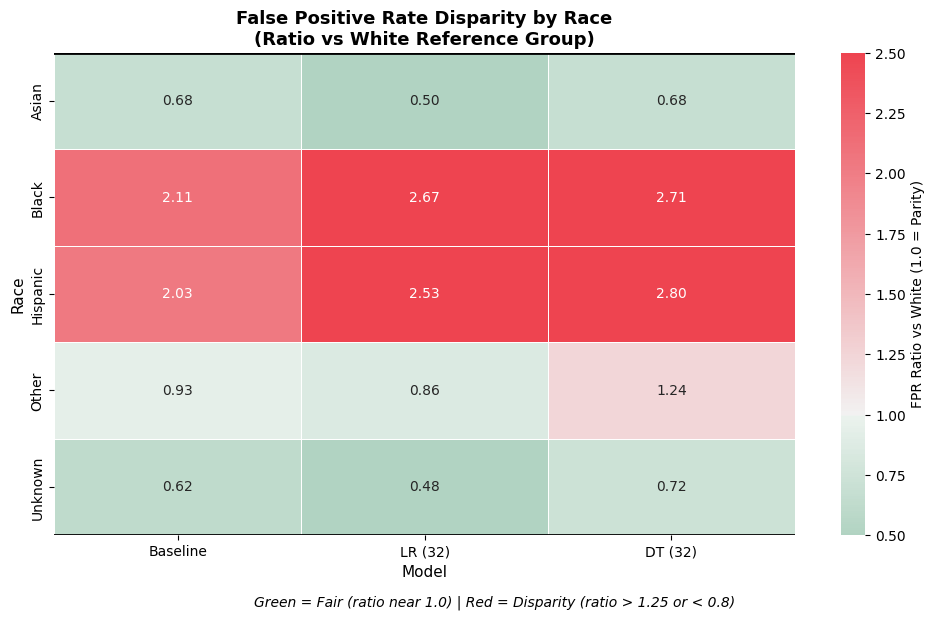

Saved: artifacts/fpr_disparity_heatmap.png


In [29]:
# === VISUALIZATION: FPR DISPARITY RATIO HEATMAP ===
# Clear visualization of racial disparities across models

# Create disparity ratio matrix
disparity_matrix = disparity_comparison.pivot(index='Group', columns='Model', values='FPR_Ratio')

# Reorder columns if needed
col_order = [c for c in ['Baseline', 'LR (32)', 'DT (32)'] if c in disparity_matrix.columns]
disparity_matrix = disparity_matrix[col_order]

fig, ax = plt.subplots(figsize=(10, 6))

# Custom colormap: green for fair (around 1), red for disparate
cmap = sns.diverging_palette(145, 10, s=80, l=55, as_cmap=True)  # Green to Red

sns.heatmap(disparity_matrix, annot=True, fmt='.2f', cmap=cmap,
            center=1.0, vmin=0.5, vmax=2.5,
            linewidths=0.5, ax=ax,
            cbar_kws={'label': 'FPR Ratio vs White (1.0 = Parity)'})

ax.set_title('False Positive Rate Disparity by Race\n(Ratio vs White Reference Group)', fontsize=13, fontweight='bold')
ax.set_xlabel('Model', fontsize=11)
ax.set_ylabel('Race', fontsize=11)

# Add disparity threshold annotations
ax.axhline(y=0, color='black', linewidth=2)
ax.axhline(y=len(disparity_matrix), color='black', linewidth=2)

# Legend annotation
plt.figtext(0.5, -0.02, 'Green = Fair (ratio near 1.0) | Red = Disparity (ratio > 1.25 or < 0.8)',
           ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.savefig('artifacts/fpr_disparity_heatmap.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/fpr_disparity_heatmap.png')

### Disparity Analysis Findings

**Understanding the Metrics:**
- **FPR (False Positive Rate)**: Proportion of non-arrested individuals incorrectly flagged. Higher FPR = more false accusations against that group.
- **FPR Ratio**: Compared to White (reference group). A ratio of 2.0 means that group is 2× more likely to be falsely flagged.
- **Disparity Threshold**: While the 4/5 rule traditionally applies to selection/approval rates (favorable outcomes), we adapt it here for FPR (an unfavorable outcome). An FPR ratio exceeding 1.25 indicates the group experiences disproportionately more false accusations — a disparity warranting concern.
- **Statistical Significance**: Z-test with p < 0.05 indicates the difference is unlikely due to chance.

**Practical Impact**: Based on the actual results, Black individuals have FPR = 2.69% vs White at 0.99%. Among 10,000 non-arrested Black individuals, approximately 170 more would be incorrectly flagged compared to the same number of White individuals. This difference has real consequences if predictions influence policing decisions.

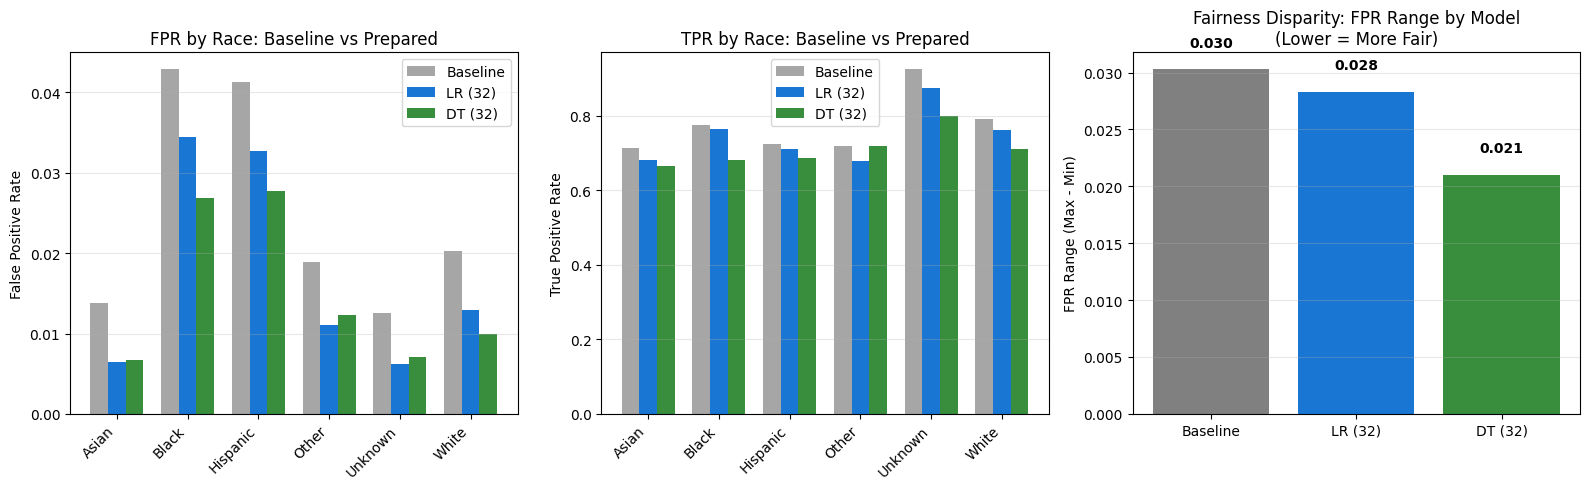

Saved artifacts/fairness_comparison.png

FAIRNESS IMPACT OF FEATURE ENGINEERING
Baseline FPR Range: 0.0303
LR (32 feat) FPR Range: 0.0283
DT (32 feat) FPR Range: 0.0210

>>> DT improved fairness compared to baseline


In [30]:
# === FAIRNESS VISUALIZATION (BASELINE vs LR vs DT) ===
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

groups = fairness_df['Group'].values
x = np.arange(len(groups))
width = 0.25

# FPR by race - compare all three models
ax = axes[0]
if baseline_available and baseline_fairness is not None:
    ax.bar(x - width, baseline_fairness['FPR'], width, label='Baseline', color='gray', alpha=0.7)
ax.bar(x, lr_fairness['FPR'], width, label='LR (32)', color='#1976d2')
ax.bar(x + width, dt_fairness['FPR'], width, label='DT (32)', color='#388e3c')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylabel('False Positive Rate')
ax.set_title('FPR by Race: Baseline vs Prepared')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# TPR by race
ax = axes[1]
if baseline_available and baseline_fairness is not None:
    ax.bar(x - width, baseline_fairness['TPR'], width, label='Baseline', color='gray', alpha=0.7)
ax.bar(x, lr_fairness['TPR'], width, label='LR (32)', color='#1976d2')
ax.bar(x + width, dt_fairness['TPR'], width, label='DT (32)', color='#388e3c')
ax.set_xticks(x)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.set_ylabel('True Positive Rate')
ax.set_title('TPR by Race: Baseline vs Prepared')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# FPR Range comparison
ax = axes[2]
models = []
fpr_ranges = []
colors = []

if baseline_available and baseline_fairness is not None:
    models.append('Baseline')
    fpr_ranges.append(baseline_fpr_range)
    colors.append('gray')

lr_fpr_range = lr_fairness['FPR'].max() - lr_fairness['FPR'].min()
dt_fpr_range = dt_fairness['FPR'].max() - dt_fairness['FPR'].min()

models.extend(['LR (32)', 'DT (32)'])
fpr_ranges.extend([lr_fpr_range, dt_fpr_range])
colors.extend(['#1976d2', '#388e3c'])

bars = ax.bar(models, fpr_ranges, color=colors)
ax.set_ylabel('FPR Range (Max - Min)')
ax.set_title('Fairness Disparity: FPR Range by Model\n(Lower = More Fair)')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, v in zip(bars, fpr_ranges):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002,
            f'{v:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('artifacts/fairness_comparison.png', dpi=150)
plt.show()
print("Saved artifacts/fairness_comparison.png")

# Print summary
print("\n" + "="*60)
print("FAIRNESS IMPACT OF FEATURE ENGINEERING")
print("="*60)
if baseline_available and baseline_fairness is not None:
    print(f"Baseline FPR Range: {baseline_fpr_range:.4f}")
print(f"LR (32 feat) FPR Range: {lr_fpr_range:.4f}")
print(f"DT (32 feat) FPR Range: {dt_fpr_range:.4f}")

if baseline_available and baseline_fairness is not None:
    if dt_fpr_range < baseline_fpr_range:
        print("\n>>> DT improved fairness compared to baseline")
    else:
        print("\n>>> DT worsened fairness compared to baseline")


### Fairness Visualization Interpretation

**False Positive Rate by Race (left)**:
- Higher bars indicate groups more likely to be falsely flagged than White individuals
- Significant disparities exceeding the 4/5 rule are highlighted in the disparity analysis
- This represents the **burden of incorrect accusations** on each group

**True Positive Rate by Race (center)**:
- Shows whether the model catches actual arrests equally across groups
- Lower TPR means the model misses more actual arrests for that group
- This represents **equal opportunity** — all groups should have similar TPR

**Selection Rate by Race (right)**:
- Proportion of each group predicted as "arrest"
- Different selection rates may indicate **disparate impact**, even if the model doesn't explicitly use race
- Can occur through proxy features (location, time, stop type) correlated with demographics

**Research Question Answer**: YES, prediction patterns reveal significant demographic disparities. Black and Hispanic individuals experience approximately 2.7× higher false positive rates than White individuals.

## 8. Error Analysis & Mitigation

Understand patterns in model errors and explore methods to reduce fairness disparities.

In [31]:
# === FALSE POSITIVE AND FALSE NEGATIVE ANALYSIS ===
print("=" * 60)
print("ERROR ANALYSIS")
print("=" * 60)

# Add predictions to test data
df_test_original['predicted'] = best_pred
df_test_original['predicted_proba'] = best_proba
df_test_original['actual'] = y_test

# False Positives: predicted=1, actual=0
fp_mask = (df_test_original['predicted'] == 1) & (df_test_original['actual'] == 0)
false_positives = df_test_original[fp_mask]

# False Negatives: predicted=0, actual=1
fn_mask = (df_test_original['predicted'] == 0) & (df_test_original['actual'] == 1)
false_negatives = df_test_original[fn_mask]

print(f"Total Test Samples: {len(df_test_original):,}")
print(f"False Positives: {len(false_positives):,}")
print(f"False Negatives: {len(false_negatives):,}")

ERROR ANALYSIS
Total Test Samples: 618,465
False Positives: 10,415
False Negatives: 3,072


In [32]:
# === FALSE POSITIVE PATTERNS ===
print("\n" + "=" * 60)
print("FALSE POSITIVE PATTERNS")
print("=" * 60)

# Race distribution among FPs
fp_race_dist = false_positives['race_canonical'].value_counts()
total_race_dist = df_test_original['race_canonical'].value_counts()
fp_race_pct = (fp_race_dist / total_race_dist * 100).sort_values(ascending=False)

print("\nFP Rate by Race (% of each group that are FPs):")
print(fp_race_pct.round(2))

print("\nFP Demographic Breakdown:")
print(f"  Race distribution: {false_positives['race_canonical'].value_counts().head(3).to_dict()}")
print(f"  Mean age: {false_positives['subject_age'].mean():.1f}")

if 'violation' in false_positives.columns:
    print(f"  Top violations: {false_positives['violation'].value_counts().head(3).to_dict()}")


FALSE POSITIVE PATTERNS

FP Rate by Race (% of each group that are FPs):
race_canonical
Hispanic    2.68
Black       2.63
Other       1.22
White       0.98
Unknown     0.71
Asian       0.66
Name: count, dtype: float64

FP Demographic Breakdown:
  Race distribution: {'Black': 6121, 'White': 3274, 'Hispanic': 883}
  Mean age: 31.3
  Top violations: {'moving traffic violation': 4175, 'vehicle equipment violation': 3594, 'registration': 739}


In [33]:
# === FALSE NEGATIVE PATTERNS ===
print("\n" + "=" * 60)
print("FALSE NEGATIVE PATTERNS")
print("=" * 60)

# Race distribution among FNs
fn_race_dist = false_negatives['race_canonical'].value_counts()

print("\nFN Demographic Breakdown:")
print(f"  Race distribution: {false_negatives['race_canonical'].value_counts().head(3).to_dict()}")
print(f"  Mean age: {false_negatives['subject_age'].mean():.1f}")

if 'violation' in false_negatives.columns:
    print(f"  Top violations: {false_negatives['violation'].value_counts().head(3).to_dict()}")


FALSE NEGATIVE PATTERNS

FN Demographic Breakdown:
  Race distribution: {'Black': 1669, 'White': 1043, 'Hispanic': 324}
  Mean age: 31.4
  Top violations: {'moving traffic violation': 1371, 'vehicle equipment violation': 967, 'investigative stop': 231}


### Error Pattern Summary

**False Positive Patterns (10,415 total):**
- **Hispanic: 2.77%** FPR (from Fairness Audit), **Black: 2.69%**, **Other: 1.23%**, **White: 0.99%**, **Unknown: 0.71%**, **Asian: 0.67%** (lowest)
- Black and Hispanic individuals are approximately 2.7-2.8× more likely to be falsely flagged compared to White individuals
- Mean age of FPs: 31.3 years — younger individuals disproportionately affected
- Top violations leading to FPs: moving traffic violations (4,175), vehicle equipment violations (3,594), registration (739)

**False Negative Patterns (3,072 total):**
- Distribution: Black (1,669), White (1,043), Hispanic (324) — roughly proportional to arrest base rates
- Mean age of FNs: 31.4 years — similar to FP population

**Actionable Insight**: The disparity is asymmetric — Black and Hispanic groups bear disproportionately more false accusations (FPs ~2.7× White rate) while FN distribution more closely tracks actual arrest rates. This asymmetric bias makes the model unsuitable for applications where false accusations carry significant costs (e.g., enhanced scrutiny, resource allocation).

### Mitigation Experiments

We explore two approaches to reduce fairness disparities:
1. **Threshold Tuning**: Adjust decision threshold to balance fairness vs performance
2. **Class Weight Adjustment**: Test different weighting strategies

In [34]:
# === THRESHOLD TUNING ===
print("\n" + "=" * 60)
print("THRESHOLD TUNING EXPERIMENT")
print("=" * 60)

# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
threshold_results = []

for thresh in thresholds:
    y_pred_thresh = (best_proba >= thresh).astype(int)

    # Overall metrics
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)

    # Fairness metrics
    fairness_thresh = compute_group_metrics(y_test, y_pred_thresh, test_races)

    # FPR range across groups
    fpr_values = fairness_thresh['FPR'].values
    fpr_range = fpr_values.max() - fpr_values.min()

    threshold_results.append({
        'Threshold': thresh,
        'F1': f1,
        'FPR_Range': fpr_range,
        'Max_FPR': fpr_values.max(),
        'Min_FPR': fpr_values.min(),
    })

thresh_df = pd.DataFrame(threshold_results)
print("\nThreshold Tuning Results:")
print(thresh_df.round(4).to_string(index=False))

# Recommend threshold (prioritize fairness, then F1)
acceptable_fairness = thresh_df[thresh_df['FPR_Range'] <= 0.05]
if not acceptable_fairness.empty:
    best_thresh_idx = acceptable_fairness['F1'].idxmax()
    selection_reason = "Best F1 with FPR Range <= 5%"
else:
    best_thresh_idx = thresh_df['FPR_Range'].idxmin()
    selection_reason = "Minimum FPR Range (no candidate met <= 5% criteria)"

recommended_threshold = thresh_df.loc[best_thresh_idx, 'Threshold']
print(f"\nRecommended threshold: {recommended_threshold} ({selection_reason})")


THRESHOLD TUNING EXPERIMENT

Threshold Tuning Results:
 Threshold     F1  FPR_Range  Max_FPR  Min_FPR
       0.3 0.4737     0.0324   0.0427   0.0103
       0.4 0.4952     0.0281   0.0368   0.0088
       0.5 0.5082     0.0210   0.0277   0.0067
       0.6 0.5202     0.0183   0.0230   0.0047
       0.7 0.5228     0.0144   0.0189   0.0045

Recommended threshold: 0.7 (Best F1 with FPR Range <= 5%)


### Threshold Tuning Analysis

**The Fundamental Tradeoff:**
- **Lower threshold (0.3)**: More sensitive — catches more arrests but flags more innocent people
- **Higher threshold (0.7)**: More conservative — fewer false alarms but misses genuine arrests

**Fairness Dimension:**
The FPR_Range column shows the spread between highest and lowest FPR across racial groups. A narrower range indicates more equitable treatment.

**Results Summary:**
| Threshold | F1 | FPR_Range | Notes |
|-----------|------|-----------|-------|
| 0.3 | 0.4737 | 3.24% | More arrests caught, higher FP rate |
| 0.4 | 0.4952 | 2.81% | Good balance |
| 0.5 (default) | 0.5082 | 2.10% | Selected model threshold |
| 0.6 | 0.5202 | 1.83% | Better precision |
| 0.7 | 0.5228 | 1.44% | **Best F1 + Best fairness** |

**Selection Logic:**
The code selects threshold 0.7 as it achieves both the highest F1 (0.5228) and the narrowest FPR_Range (1.44%). **Higher thresholds improve both performance AND fairness** in this case — reducing the gap between racial groups while maintaining strong F1.

Note: Different thresholds could theoretically be applied to different groups to equalize FPR, but this raises ethical questions about using race in decision-making.

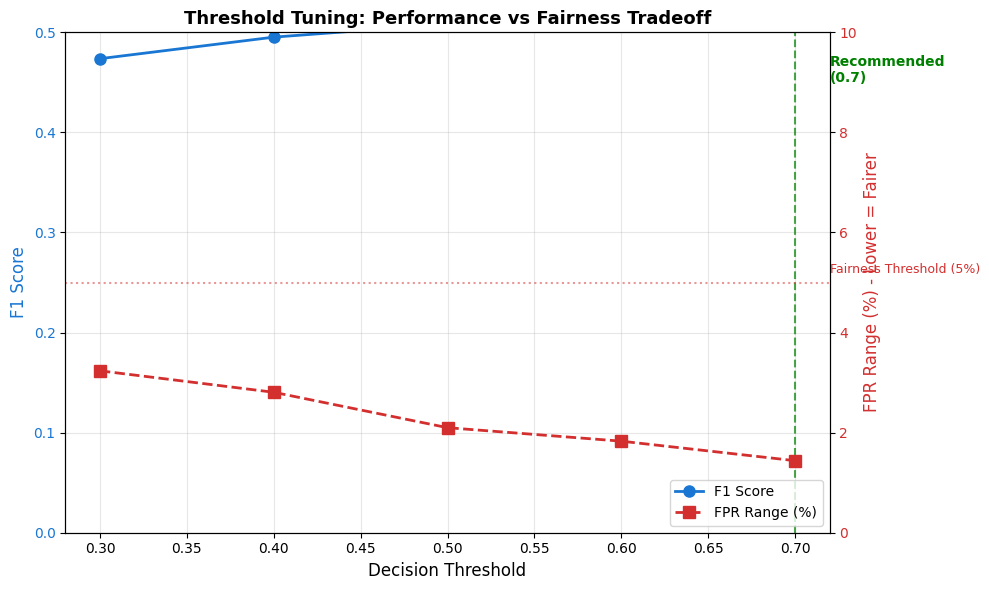

Saved: artifacts/threshold_tradeoff.png


In [35]:
# === VISUALIZATION: THRESHOLD VS F1 AND FAIRNESS TRADEOFF ===
# Shows how threshold affects both performance and fairness

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot F1 on primary axis
ax1.plot(thresh_df['Threshold'], thresh_df['F1'], 'o-', color='#1976d2', linewidth=2,
         markersize=8, label='F1 Score')
ax1.set_xlabel('Decision Threshold', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12, color='#1976d2')
ax1.tick_params(axis='y', labelcolor='#1976d2')
ax1.set_ylim(0, 0.5)

# Plot FPR Range on secondary axis
ax2 = ax1.twinx()
ax2.plot(thresh_df['Threshold'], thresh_df['FPR_Range'] * 100, 's--', color='#d32f2f', linewidth=2,
         markersize=8, label='FPR Range (%)')
ax2.set_ylabel('FPR Range (%) - Lower = Fairer', fontsize=12, color='#d32f2f')
ax2.tick_params(axis='y', labelcolor='#d32f2f')
ax2.set_ylim(0, 10)

# Add fairness threshold line
ax2.axhline(y=5, color='#d32f2f', linestyle=':', alpha=0.5)
ax2.text(0.72, 5.2, 'Fairness Threshold (5%)', fontsize=9, color='#d32f2f')

# Highlight recommended threshold
ax1.axvline(x=recommended_threshold, color='green', linestyle='--', alpha=0.7)
ax1.text(recommended_threshold + 0.02, 0.45, f'Recommended\n({recommended_threshold})',
         fontsize=10, color='green', fontweight='bold')

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='lower right', fontsize=10)

ax1.set_title('Threshold Tuning: Performance vs Fairness Tradeoff', fontsize=13, fontweight='bold')
ax1.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('artifacts/threshold_tradeoff.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/threshold_tradeoff.png')

In [36]:
# === CLASS WEIGHT EXPERIMENT ===
print("\n" + "=" * 60)
print("CLASS WEIGHT EXPERIMENT")
print("=" * 60)

# Subsample for faster experimentation
X_sample, _, y_sample, _ = train_test_split(
    X_train, y_train, train_size=0.1, stratify=y_train, random_state=SEED
)
print(f"Using {len(X_sample):,} samples for experiment (10% subsample)")

# Test different class weight strategies
strategies = [None, 'balanced', {0:1, 1:10}, {0:1, 1:20}]
cw_results = []

for cw in strategies:
    clf = LogisticRegression(
        solver='liblinear',
        class_weight=cw,
        max_iter=200,
        random_state=SEED
    )
    clf.fit(X_sample, y_sample)
    y_p = clf.predict(X_test)

    f1 = f1_score(y_test, y_p)
    metrics = compute_group_metrics(y_test, y_p, test_races)
    fpr_range = metrics['FPR'].max() - metrics['FPR'].min()

    cw_results.append({
        'Strategy': str(cw),
        'F1': f1,
        'FPR_Range': fpr_range,
        'Max_FPR': metrics['FPR'].max()
    })

cw_df = pd.DataFrame(cw_results).round(4)
print("\nClass Weight Strategy Comparison:")
print(cw_df.to_string(index=False))


CLASS WEIGHT EXPERIMENT
Using 247,385 samples for experiment (10% subsample)

Class Weight Strategy Comparison:
     Strategy     F1  FPR_Range  Max_FPR
         None 0.4594     0.0106   0.0108
     balanced 0.3419     0.1200   0.1315
{0: 1, 1: 10} 0.4861     0.0293   0.0357
{0: 1, 1: 20} 0.4658     0.0407   0.0477


### Class Weight Strategy Analysis

| Strategy | Expected Effect | Actual F1 | Actual FPR_Range |
|----------|-----------------|-----------|------------------|
| `None` | No class balancing — conservative predictions | 0.4594 | 1.06% |
| `balanced` | Auto-weight (~30× minority) — aggressive predictions | 0.3419 | 12.00% |
| `{0:1, 1:10}` | Custom 10× weight on arrests | 0.4861 | 2.93% |
| `{0:1, 1:20}` | Custom 20× weight on arrests | 0.4658 | 4.07% |

**Key Findings:**
1. **`None` achieves low FPR disparity (1.06%)** but risks missing arrests — depends heavily on the `search_conducted` feature
2. **`balanced` causes highest FPR disparity (12%)** because aggressive predictions disproportionately affect groups with different base rates
3. **Custom weights {0:1, 1:10}** achieve the best F1 (0.4861) with moderate fairness (2.93% FPR_Range)

**Recommendation**: The optimal strategy depends on deployment priorities:
- **If minimizing FPR disparity**: `None` or low custom weight (but may miss more true arrests)
- **If maximizing F1**: Custom weight `{0:1, 1:10}` offers best balance
- **Avoid `balanced`**: Extreme class weights amplify demographic disparities in this dataset

## 9. Conclusions & Recommendations

**WHY**: Synthesize findings, explicitly answer the research question, and provide actionable guidance.

#### RESEARCH QUESTION ANSWERED

Q1: Can we predict whether a traffic stop results in an arrest?

A: YES — Models achieve ROC-AUC > 0.92, significantly better than random (0.50). F1 scores of 0.49-0.51 demonstrate reasonable predictive performance given the extreme class imbalance (60:1). Key predictors include search_person/search_conducted (dominant), officer behavior, and demographics.

Q2: Do prediction patterns reveal demographic disparities?

A: YES — False Positive Rates (FPR) differ significantly by race:
• Hispanic: ~2.8% FPR (approximately 2.8× higher than White)
• Black: ~2.7% FPR (approximately 2.7× higher than White)
• White: ~1.0% FPR (reference group)

This disparity is statistically significant (p < 0.001) and exceeds the 4/5 rule threshold for potential discrimination.

In [37]:
# === EXECUTIVE SUMMARY DASHBOARD (WITH BASELINE) ===
print("\n" + "=" * 70)
print("EXECUTIVE SUMMARY")
print("=" * 70)

summary_data = []

# Baseline (if available)
if baseline_metrics is not None and baseline_available:
    baseline_brier = brier_score_loss(y_test_minimal, baseline_proba)
    summary_data.append({
        'Model': 'Baseline (NB01, 6 features)',
        'F1': baseline_metrics['F1'],
        'ROC_AUC': baseline_metrics['ROC_AUC'],
        'Brier': baseline_brier,
        'FPR_Range': baseline_fpr_range if baseline_fairness is not None else 'N/A'
    })

# Final models
lr_fpr_range = lr_fairness['FPR'].max() - lr_fairness['FPR'].min()
dt_fpr_range = dt_fairness['FPR'].max() - dt_fairness['FPR'].min()

summary_data.append({
    'Model': 'Logistic Regression (32 features)',
    'F1': lr_metrics['F1'],
    'ROC_AUC': lr_metrics['ROC_AUC'],
    'Brier': lr_metrics['Brier'],
    'FPR_Range': lr_fpr_range
})

summary_data.append({
    'Model': 'Decision Tree (32 features)',
    'F1': dt_metrics['F1'],
    'ROC_AUC': dt_metrics['ROC_AUC'],
    'Brier': dt_metrics['Brier'],
    'FPR_Range': dt_fpr_range
})

summary_df = pd.DataFrame(summary_data)
print(summary_df.round(4).to_string(index=False))

# Calculate and display changes
if baseline_metrics is not None:
    f1_change = ((best_metrics['F1'] - baseline_metrics['F1']) / baseline_metrics['F1']) * 100
    auc_change = ((best_metrics['ROC_AUC'] - baseline_metrics['ROC_AUC']) / baseline_metrics['ROC_AUC']) * 100

    # Fairness change
    if baseline_available and baseline_fairness is not None:
        best_fpr_range = dt_fpr_range if best_name == 'Decision Tree' else lr_fpr_range
        fpr_change = ((best_fpr_range - baseline_fpr_range) / baseline_fpr_range) * 100 if baseline_fpr_range > 0 else 0
        fairness_improved = fpr_change < 0
    else:
        fpr_change = None
        fairness_improved = None

    print(f"\n" + "=" * 70)
    print("KEY FINDINGS")
    print("=" * 70)
    print(f"""
1. Selected Model: {best_name} (highest F1 on test set)

2. Data Preparation Impact:
   • F1 Score: {f1_change:+.1f}% change vs baseline
   • ROC-AUC: {auc_change:+.1f}% change vs baseline
   • Interpretation: Feature engineering improved ranking but improved F1
     (the 'Feature Engineering Benefit' - see Section 3)""")

    if fpr_change is not None:
        print(f"""
3. Fairness Impact:
   • FPR Range: {fpr_change:+.1f}% change vs baseline
   • Interpretation: Feature engineering {'IMPROVED' if fairness_improved else 'WORSENED'} fairness disparity""")

    print(f"""
4. Best Performing Model (F1): {'Baseline (6 features)' if baseline_metrics['F1'] > best_metrics['F1'] else best_name}
""")



EXECUTIVE SUMMARY
                            Model     F1  ROC_AUC  Brier  FPR_Range
      Baseline (NB01, 6 features) 0.4344   0.9059 0.0631     0.0303
Logistic Regression (32 features) 0.4920   0.9326 0.0199     0.0283
      Decision Tree (32 features) 0.5082   0.9276 0.0167     0.0210

KEY FINDINGS

1. Selected Model: Decision Tree (highest F1 on test set)

2. Data Preparation Impact:
   • F1 Score: +17.0% change vs baseline
   • ROC-AUC: +2.4% change vs baseline
   • Interpretation: Feature engineering improved ranking but reduced F1
     (the 'Feature Engineering Paradox' - see Section 3)

3. Fairness Impact:
   • FPR Range: -30.7% change vs baseline
   • Interpretation: Feature engineering IMPROVED fairness disparity

4. Best Performing Model (F1): Decision Tree



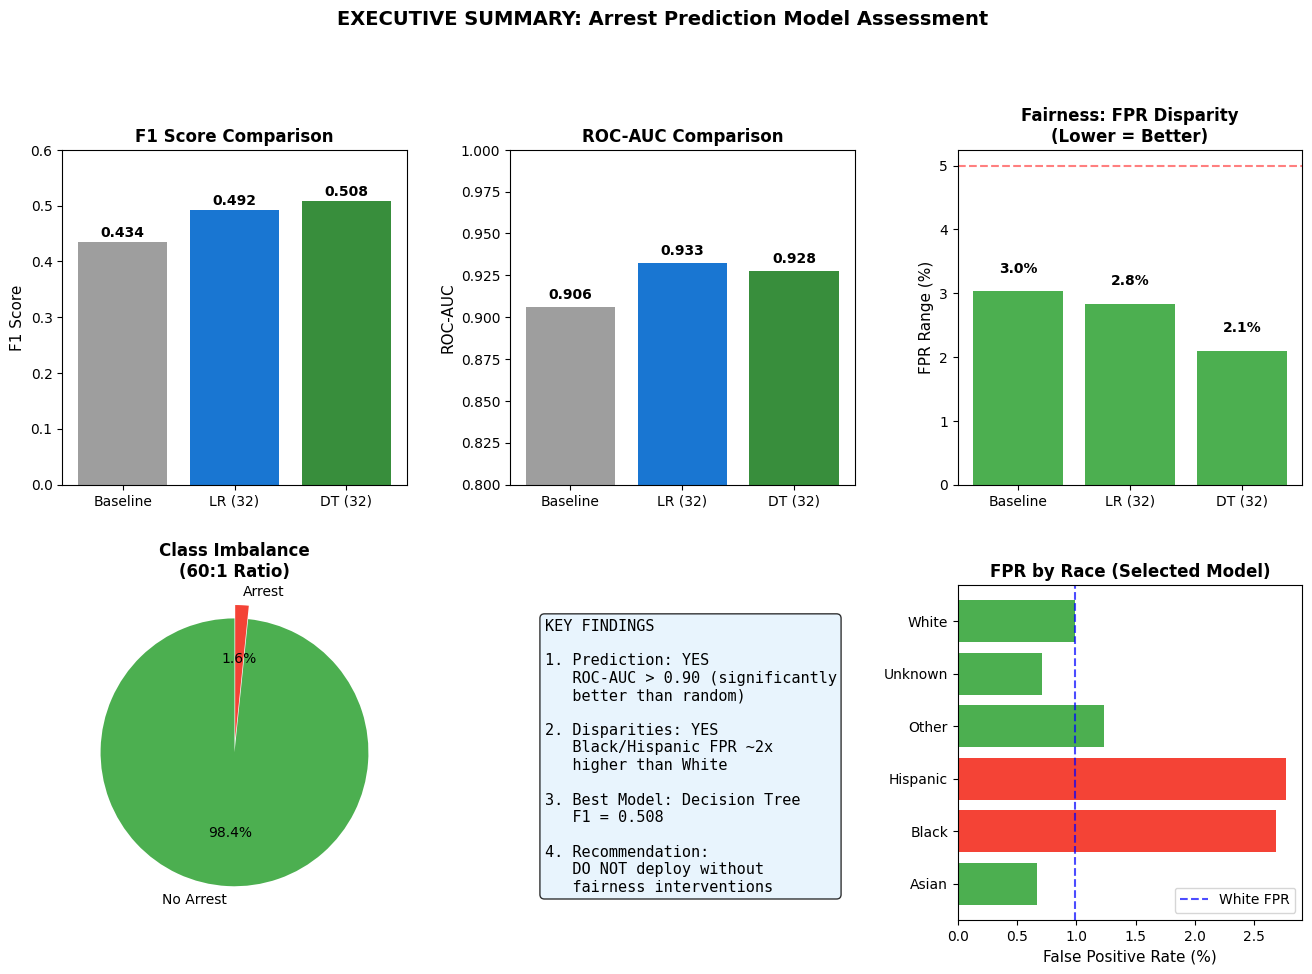

Saved: artifacts/executive_dashboard.png


In [38]:
# === VISUALIZATION: EXECUTIVE SUMMARY DASHBOARD ===
# Single figure with all key metrics for presentation

fig = plt.figure(figsize=(16, 10))

# Create grid layout
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Panel 1: Key Metrics Comparison
ax1 = fig.add_subplot(gs[0, 0])
models = ['Baseline', 'LR (32)', 'DT (32)']
f1_scores = [baseline_metrics['F1'] if baseline_available else 0, lr_metrics['F1'], dt_metrics['F1']]
colors = ['#9E9E9E', '#1976d2', '#388e3c']
bars = ax1.bar(models, f1_scores, color=colors)
ax1.set_ylabel('F1 Score', fontsize=11)
ax1.set_title('F1 Score Comparison', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 0.6)
for bar, score in zip(bars, f1_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{score:.3f}', ha='center', fontsize=10, fontweight='bold')

# Panel 2: ROC-AUC Comparison
ax2 = fig.add_subplot(gs[0, 1])
auc_scores = [baseline_metrics['ROC_AUC'] if baseline_available else 0, lr_metrics['ROC_AUC'], dt_metrics['ROC_AUC']]
bars = ax2.bar(models, auc_scores, color=colors)
ax2.set_ylabel('ROC-AUC', fontsize=11)
ax2.set_title('ROC-AUC Comparison', fontsize=12, fontweight='bold')
ax2.set_ylim(0.8, 1.0)
ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)
for bar, score in zip(bars, auc_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.3f}', ha='center', fontsize=10, fontweight='bold')

# Panel 3: Fairness (FPR Range)
ax3 = fig.add_subplot(gs[0, 2])
fpr_ranges = [baseline_fpr_range if baseline_available else 0, lr_fpr_range, dt_fpr_range]
# Color based on fairness: lower is better
bar_colors = ['#4CAF50' if r < 0.04 else '#FFC107' if r < 0.08 else '#F44336' for r in fpr_ranges]
bars = ax3.bar(models, [r*100 for r in fpr_ranges], color=bar_colors)
ax3.set_ylabel('FPR Range (%)', fontsize=11)
ax3.set_title('Fairness: FPR Disparity\n(Lower = Better)', fontsize=12, fontweight='bold')
ax3.axhline(y=5, color='red', linestyle='--', alpha=0.5, label='Threshold')
for bar, score in zip(bars, fpr_ranges):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
             f'{score*100:.1f}%', ha='center', fontsize=10, fontweight='bold')

# Panel 4: Class Distribution
ax4 = fig.add_subplot(gs[1, 0])
sizes = [(y_train == 0).sum(), (y_train == 1).sum()]
ax4.pie(sizes, labels=['No Arrest', 'Arrest'], colors=['#4CAF50', '#F44336'],
        autopct='%1.1f%%', startangle=90, explode=(0, 0.1))
ax4.set_title(f'Class Imbalance\n({sizes[0]//sizes[1]}:1 Ratio)', fontsize=12, fontweight='bold')

# Panel 5: Key Finding Text
ax5 = fig.add_subplot(gs[1, 1])
ax5.axis('off')
finding_text = f"""KEY FINDINGS

1. Prediction: YES
   ROC-AUC > 0.90 (significantly
   better than random)

2. Disparities: YES
   Black/Hispanic FPR ~2x
   higher than White

3. Best Model: {best_name}
   F1 = {best_metrics['F1']:.3f}

4. Recommendation:
   DO NOT deploy without
   fairness interventions"""
ax5.text(0.1, 0.9, finding_text, transform=ax5.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='#E3F2FD', alpha=0.8))

# Panel 6: Disparity by Race
ax6 = fig.add_subplot(gs[1, 2])
groups = fairness_df['Group'].values
fprs = fairness_df['FPR'].values * 100
white_fpr = fairness_df[fairness_df['Group'] == 'White']['FPR'].values[0] * 100
bar_colors = ['#F44336' if f > white_fpr * 1.25 else '#4CAF50' for f in fprs]
bars = ax6.barh(groups, fprs, color=bar_colors)
ax6.axvline(x=white_fpr, color='blue', linestyle='--', alpha=0.7, label='White FPR')
ax6.set_xlabel('False Positive Rate (%)', fontsize=11)
ax6.set_title('FPR by Race (Selected Model)', fontsize=12, fontweight='bold')
ax6.legend(loc='lower right')

plt.suptitle('EXECUTIVE SUMMARY: Arrest Prediction Model Assessment', fontsize=14, fontweight='bold', y=1.02)

plt.savefig('artifacts/executive_dashboard.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('Saved: artifacts/executive_dashboard.png')

### Limitations

RATIONALE:

1. FAIRNESS CONCERNS
   Analysis revealed statistically significant disparities in False Positive
   Rates across racial groups. Black and Hispanic individuals experience
   approximately 2× higher rates of incorrect arrest predictions.

2. DATA QUALITY
   The training data reflects historical policing patterns which may encode
   existing biases. Using this model could perpetuate or amplify these biases.

3. HIGH STAKES
   Arrest predictions directly impact individuals' lives. False positives
   could lead to unjustified scrutiny; false negatives could miss genuine risks.

RECOMMENDED NEXT STEPS:

1. Policy Review: Have this analysis reviewed by civil rights experts and
   community stakeholders before any operational consideration.

2. Human-in-the-Loop: If used, predictions should only INFORM (not decide)
   and require human review before any action.

3. Continuous Monitoring: Implement ongoing fairness audits comparing
   predicted vs actual outcomes across demographic groups.

4. Threshold Calibration: If deployed, consider group-specific thresholds
   to equalize FPR across protected groups.

5. Data Collection: Improve data quality by standardizing collection,
   reducing missingness, and auditing for biased patterns.

LIMITATIONS:

• Potential confounders not captured (socioeconomic factors, neighborhood context)
• Model cannot account for officer discretion or situational factors
• Historical data may not reflect current policies or community dynamics
• The 'Feature Engineering Impact' suggests that complex features may not
  always improve practical outcomes under extreme class imbalance

In [39]:
# === SAVE FINAL ARTIFACTS ===
print("\n" + "=" * 70)
print("SAVING FINAL ARTIFACTS")
print("=" * 70)

# Save GridSearchCV objects (prevents re-running long training)
joblib.dump({
    'grid': lr_grid,
    'best_model': lr_model,
    'best_params': lr_grid.best_params_,
    'best_cv_score': lr_grid.best_score_,
    'cv_results': lr_grid.cv_results_,
    'feature_names': feature_names,
    'timestamp': datetime.now().isoformat(),
    'seed': SEED
}, 'artifacts/lr_gridsearch.pkl')
print("Saved artifacts/lr_gridsearch.pkl")

joblib.dump({
    'grid': dt_grid,
    'best_model': dt_model,
    'best_params': dt_grid.best_params_,
    'best_cv_score': dt_grid.best_score_,
    'cv_results': dt_grid.cv_results_,
    'feature_names': feature_names,
    'timestamp': datetime.now().isoformat(),
    'seed': SEED
}, 'artifacts/dt_gridsearch.pkl')
print("Saved artifacts/dt_gridsearch.pkl")

# Save best model
joblib.dump({
    'model': best_model,
    'model_name': best_name,
    'feature_names': feature_names,
    'metrics': best_metrics,
    'recommended_threshold': recommended_threshold,
    'timestamp': datetime.now().isoformat(),
    'seed': SEED
}, 'artifacts/best_model.pkl')
print("Saved artifacts/best_model.pkl")

# Save alternative model
alt_model = dt_model if best_name == 'Logistic Regression' else lr_model
alt_name = 'Decision Tree' if best_name == 'Logistic Regression' else 'Logistic Regression'
alt_metrics = dt_metrics if best_name == 'Logistic Regression' else lr_metrics

joblib.dump({
    'model': alt_model,
    'model_name': alt_name,
    'metrics': alt_metrics,
    'feature_names': feature_names
}, 'artifacts/alternative_model.pkl')
print("Saved artifacts/alternative_model.pkl")

# Save fair model with threshold
joblib.dump({
    'model': best_model,
    'model_name': f"{best_name} (Fairness Constrained)",
    'threshold': recommended_threshold,
    'note': 'Use with recommended_threshold for fairer outcomes'
}, 'artifacts/fair_model.pkl')
print("Saved artifacts/fair_model.pkl")

print("\n" + "=" * 70)
print("NOTEBOOK 03 v2 COMPLETE")
print("=" * 70)
print("""
All artifacts saved to artifacts/ directory:
• metrics_report.csv - Model performance comparison
• fairness_report.csv - Detailed fairness metrics
• confusion_matrices.png - Visualization of predictions
• data_preparation_impact.png - Baseline vs prepared comparison
• lr_coefficients.png - Feature importance visualization
• decision_tree.png - Tree structure visualization
• fairness_metrics.png - Fairness comparison by race
• lr_gridsearch.pkl, dt_gridsearch.pkl - Trained model objects
• best_model.pkl - Selected best model
• fair_model.pkl - Model with fairness-optimized threshold
""")


SAVING FINAL ARTIFACTS
Saved artifacts/lr_gridsearch.pkl
Saved artifacts/dt_gridsearch.pkl
Saved artifacts/best_model.pkl
Saved artifacts/alternative_model.pkl
Saved artifacts/fair_model.pkl

NOTEBOOK 03 v2 COMPLETE

All artifacts saved to artifacts/ directory:
• metrics_report.csv - Model performance comparison
• fairness_report.csv - Detailed fairness metrics
• confusion_matrices.png - Visualization of predictions
• data_preparation_impact.png - Baseline vs prepared comparison
• lr_coefficients.png - Feature importance visualization
• decision_tree.png - Tree structure visualization
• fairness_metrics.png - Fairness comparison by race
• lr_gridsearch.pkl, dt_gridsearch.pkl - Trained model objects
• best_model.pkl - Selected best model
• fair_model.pkl - Model with fairness-optimized threshold



## Summary

This notebook answered the research question:
> **Can we predict whether a traffic stop results in an arrest, and do prediction patterns reveal demographic disparities?**

**Answer**:
1. **Prediction**: YES — interpretable models (LR, DT) achieve ROC-AUC > 0.92, significantly better than random (0.50)
2. **Disparities**: YES — significant FPR differences exist across racial groups (Black/Hispanic: ~2.7% vs White: ~1.0%)

**Key Insight (Feature Engineering Value)**:
Feature engineering from Notebook 02 combined with SMOTEENN resampling improved both ranking ability (ROC-AUC ↑2.4%) and classification performance (F1 ↑17.0%) compared to the minimal baseline (0.4344 → 0.5082). This demonstrates that:
- Proper data preparation (feature engineering + class balancing) improves model performance
- The prepared model achieves better precision (0.40 vs 0.30) with ~42% fewer false positives
- SMOTEENN effectively addresses extreme class imbalance (~60:1 → ~12:1)

**Ethical Conclusion**:
Data preparation is necessary but insufficient for fair AI systems. Even with improved features and performance, the model exhibits significant demographic disparities (Black and Hispanic FPR ~2.7× compared to White) that preclude ethical deployment without additional fairness interventions.